# BSM using different kinds of volitility

## Data Binding

In [14]:
import pandas_market_calendars as mcal
import pandas as pd
from visualize import *
from ic_group import *
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.stats import norm
pd.set_option('display.max_columns',None) # avoid omitting columns

# Define the China stock exchange calendar
china_calendar = mcal.get_calendar('XSHG')  # 'XSHG' is the code for the Shanghai Stock Exchange

# Define the date range
start_date = pd.Timestamp('2019-01-01')
end_date = pd.Timestamp('2023-06-21')

# Get the trading days between the specified dates
trading_days = china_calendar.schedule(start_date=start_date, end_date=end_date)

# Extract the trading days as a list
trading_days_list = trading_days.index.strftime('%Y-%m-%d').tolist()


In [ ]:
combined_df = pd.DataFrame()
for date in trading_days_list: # Loop over all the trading dates
    print(date)
    cb_1d = pd.read_csv("/Users/linyukai/Downloads/haxi_pe/data/bond/cross/" + date + '/1d.csv') # daily info of convertible bond
    indicator = pd.read_csv("/Users/linyukai/Downloads/haxi_pe/data/bond/cross/" + date + '/indicator.csv') # derivative indicators
    symbols = pd.read_csv("/Users/linyukai/Downloads/haxi_pe/data/bond/cross/" + date + '/symbols.csv') 
    s_1d = pd.read_csv("/Users/linyukai/Downloads/haxi_pe/data/bond/cross/" + date + '/stock_1d.csv') # daily info of stock

    # rename columns names of s_1d to avoid duplication between factors of convertible bond and respective stock.
    rename_dict = {x:'stock_' + x for x in s_1d.columns}
    rename_dict['order_book_id'] = 'stock_code'
    rename_dict['date'] = 'date' 
    rename_dict
    s_1d = s_1d.rename(columns=rename_dict)

    # merge for a single day
    merged_df = pd.merge(symbols,s_1d,on='stock_code',how='left')
    merged_df = merged_df[['order_book_id', 'value_date', 'maturity_date', 'par_value', 'coupon_rate',
        'coupon_frequency', 'coupon_method', 'compensation_rate',
        'total_issue_size', 'de_listed_date', 'stock_code',
        'conversion_start_date', 'conversion_end_date', 'redemption_price',
        'issue_price', 'call_protection', 'listed_date', 'stop_trading_date',
        'industry_code', 'industry_name', 'stock_open', 'stock_high',
        'stock_low', 'stock_close', 'stock_volume', 'stock_money',
        'stock_num_trades']]
    merged_df = pd.merge(cb_1d,merged_df,on='order_book_id',how='left')
    merged_df = pd.merge(merged_df,indicator,on=('date','order_book_id'),how='left')

    combined_df = combined_df.append(merged_df, ignore_index=True) # Add into the same DataFrame

In [12]:
combined_df['date'] = pd.to_datetime(combined_df['date']) # change the type of date columns
combined_df['conversion_price'] = 100/combined_df['conversion_coefficient'] # conversion price 
combined_df.to_hdf('cb_data.h5',"df", mode='w') # write into h5 file

In [1]:
reread = pd.read_hdf('cb_data.h5') 

<IPython.core.display.Javascript object>

## Some Graph

In [9]:
df = reread[reread['order_book_id']==list(reread['order_book_id'])[0]]

### Implied Volatility

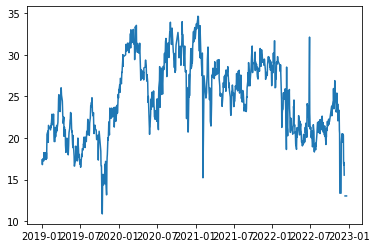

In [10]:
import matplotlib.pyplot as plt
plt.plot(df['date'],df['IMPLIEDVOL'])
plt.show()

### Price and Conversion Price

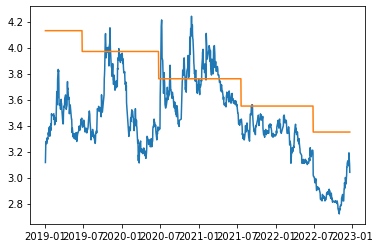

In [11]:
plt.plot(df['date'],df['stock_close'])
plt.plot(df['date'],df['conversion_price'])
plt.show()

In [126]:
data = df
Maturity_Date = data['maturity_date']
Maturity_Date=Maturity_Date.apply(lambda x:datetime.strptime(x,'%Y-%m-%d'))
t = (Maturity_Date-data['date']).apply(lambda x: x.days)/365


0         4.205479
111       4.202740
222       4.200000
333       4.191781
445       4.189041
            ...   
286653    0.254795
287115    0.252055
287577    0.249315
287744    0.241096
288447    0.238356
Length: 964, dtype: float64

In [132]:
Maturity_Date = data['maturity_date']
Maturity_Date=Maturity_Date.apply(lambda x:datetime.strptime(x,'%Y-%m-%d'))
s = data['stock_close']
x = data['conversion_price']*data['redemption_price']/100.0
t = (Maturity_Date-data['date']).apply(lambda x: x.days)/365
vol = data['IMPLIEDVOL']
r = 0.02
d1=(np.log(s/x)+(r+0.5*(vol**2))*t)/(np.sqrt(t)*vol)
d2=d1-vol*np.sqrt(t)
ret=s*norm.cdf(d1)-x*np.exp(-r*t)*norm.cdf(d2)
data['call'] = ret*100/data['conversion_price']

/Users/linyukai/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


## BSM

In [39]:
def plot_comparison(df_i,order_book_id,mode):
    """
    Show the plot of close price and theoretically predicted price.
    The volitility is also shown in the plot.
    ------
    Parameter:
    df_i(dataframe): the dataframe with the price of one mode.
    order_book_id(str)
    mode(str): chosen from 'BSM_rq_iv', 'BSM_nt_iv', 'BSM_his_vol'
    ------
    Output:
    Line plot
    """
    if mode == 'BSM_rq_iv':
        call_name='call_rq_iv'
        vol_name='IMPLIEDVOL'
    elif mode == 'BSM_nt_iv':
        call_name='call_nt_iv'
        vol_name='IV_ConvBond'
    else: # BSM_his_vol
        winlen = mode.split("_")[-1]
        call_name=f'call_historic_vol_{winlen}'
        vol_name=f'historic_vol_{winlen}'

    x = df_i['date']
    y1 = (df_i[call_name]+df_i['pure_bond_value_1']).shift(-1)
    y2 = df_i[vol_name]
    y3 = df_i['close']
    fig, ax1 = plt.subplots()

    # Plot the first dataset
    ax1.plot(x, y1, 'b-', label='BSM')
    ax1.plot(x, y3, 'r', label='close')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price', color='b')
    ax1.tick_params('y', colors='b')

    # Create the second subplot
    ax2 = ax1.twinx()

    # Plot the second dataset
    ax2.plot(x, y2, 'g', label='vol')
    ax2.set_ylabel('VOL', color='r')
    ax2.tick_params('y', colors='r')

    # Add a legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')
    plt.title(order_book_id)
    # Display the plot
    plt.show()

### RQ_IV

In [19]:
def BSM_call(data):
    """
    BS model using implied volitility from ricequant
    ------
    Parameter: data(dataframe)
    ------
    Output: dataframe
    """
    Maturity_Date = data['maturity_date']
    Maturity_Date=Maturity_Date.apply(lambda x:datetime.strptime(x,'%Y-%m-%d'))
    s = data['stock_close']
    x = data['conversion_price']*data['redemption_price']/100.0
    t = (Maturity_Date-data['date']).apply(lambda x: x.days)/365 
    vol = data['IMPLIEDVOL']
    r = 0.02
    d1=(np.log(s/x)+(r+0.5*(vol**2))*t)/(np.sqrt(t)*vol)
    d2=d1-vol*np.sqrt(t)
    ret=s*norm.cdf(d1)-x*np.exp(-r*t)*norm.cdf(d2)
    data['call_rq_iv'] = ret*100/data['conversion_price']
    return data


In [13]:
# calculating price from BS model
df_call_RQ_IV = reread.groupby('order_book_id').apply(BSM_call)

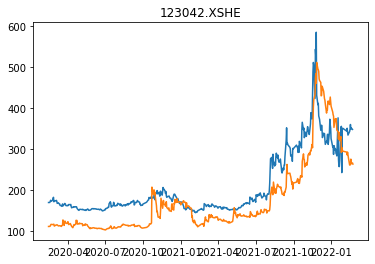

In [17]:
df_i = df_call_RQ_IV[df_call_RQ_IV['order_book_id']=='123042.XSHE']
plt.plot(df_i['date'],(df_i['call_rq_iv']+df_i['pure_bond_value_1']).shift(-1))
plt.plot(df_i['date'],df_i['close'])
plt.title('123042.XSHE')
plt.show()

In [ ]:
order_book_id_lis = list(set(df_call_RQ_IV['order_book_id']))
# plot of some examples
for i in range(20,30):
    order_book_id = order_book_id_lis[i]
    df_i = df_call_RQ_IV[df_call_RQ_IV['order_book_id']==order_book_id]
    plot_comparison(df_i,order_book_id,'BSM_rq_iv')

### Historic Volatility

In [89]:
def BSM_call_historic_vol_y(data,windowlis=[10,20,60,250]):
    """
    BS model using historic yearly volitility
    ------
    Parameter: 
    data(dataframe)
    windowlis(list)
    ------
    Output: 
    data dataframe
    """
    Maturity_Date = data['maturity_date']
    Maturity_Date=Maturity_Date.apply(lambda x:datetime.strptime(x,'%Y-%m-%d'))
    s = data['stock_close']
    x = data['conversion_price']*data['redemption_price']/100.0
    t = (Maturity_Date-data['date']).apply(lambda x: x.days)/365
    data['logreturn_y'] = 250*np.log(data['close']/data['close'].shift())
    for window in windowlis:
        data[f'historic_vol_{window}'] = data['logreturn_y'].rolling(window).var()
        vol = np.sqrt(data[f'historic_vol_{window}'])
        r = 0.02
        d1=(np.log(s/x)+(r+0.5*(vol**2))*t)/(np.sqrt(t)*vol)
        d2=d1-vol*np.sqrt(t)
        ret=s*norm.cdf(d1)-x*np.exp(-r*t)*norm.cdf(d2)
        data[f'call_historic_vol_{window}'] = ret*100/data['conversion_price']
    return data
def BSM_call_historic_vol_d(data,windowlis=[10,20,60,250]):
    """
    BS model using historic daily volitility
    ------
    Parameter: 
    data(dataframe)
    windowlis(list)
    ------
    Output: 
    data dataframe
    """
    Maturity_Date = data['maturity_date']
    Maturity_Date=Maturity_Date.apply(lambda x:datetime.strptime(x,'%Y-%m-%d'))
    s = data['stock_close']
    x = data['conversion_price']*data['redemption_price']/100.0
    t = (Maturity_Date-data['date']).apply(lambda x: x.days)/365
    data['logreturn_y'] = 250*np.log(data['close']/data['close'].shift())
    for window in windowlis:
        data[f'historic_vol_{window}'] = data['logreturn_y'].rolling(window).var()
        vol = np.sqrt(data[f'historic_vol_{window}'])/250
        r = 0.02
        d1=(np.log(s/x)+(r+0.5*(vol**2))*t)/(np.sqrt(t)*vol)
        d2=d1-vol*np.sqrt(t)
        ret=s*norm.cdf(d1)-x*np.exp(-r*t)*norm.cdf(d2)
        data[f'call_historic_vol_{window}'] = ret*100/data['conversion_price']
    return data

In [90]:
# calculating price from BS model with historic volatility 
df_call_historic_vol_y = reread.groupby('order_book_id').apply(BSM_call_historic_vol_y)
df_call_historic_vol_d = reread.groupby('order_book_id').apply(BSM_call_historic_vol_d)

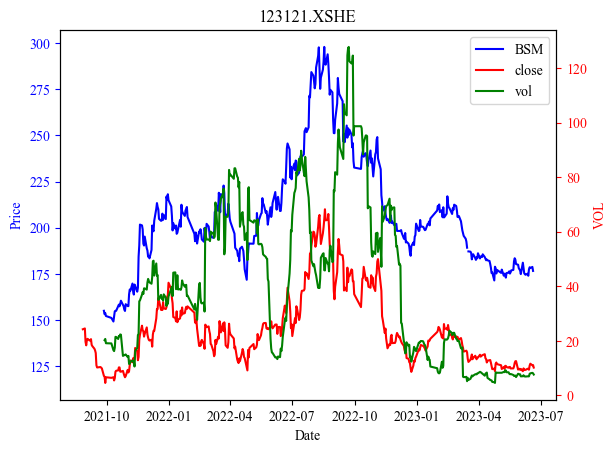

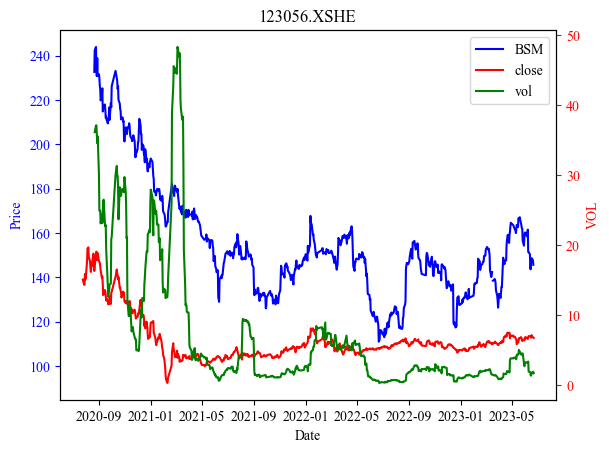

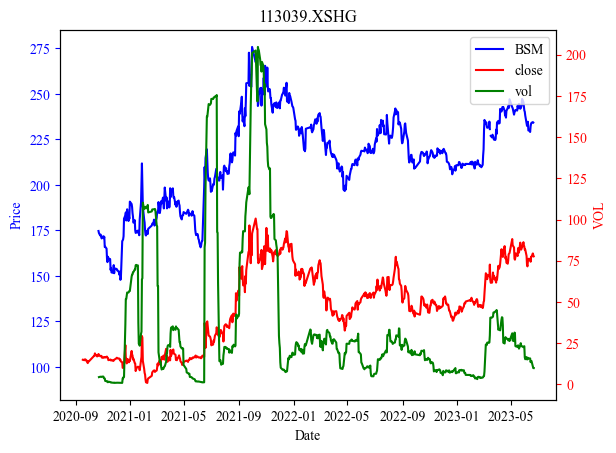

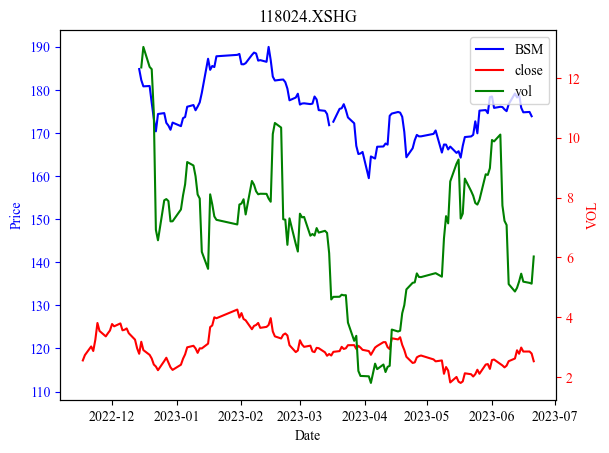

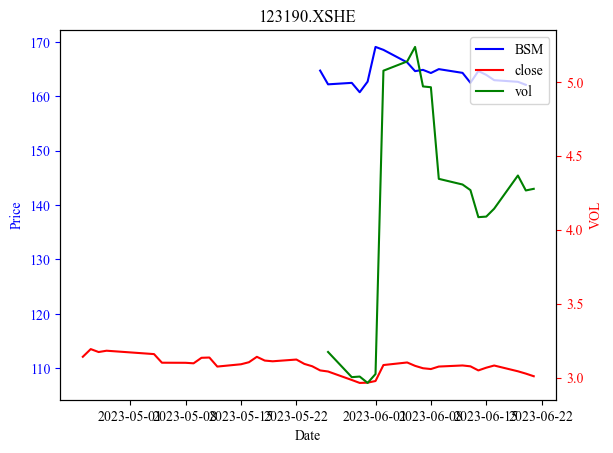

In [117]:
order_book_id_lis = list(set(df_call_historic_vol['order_book_id']))
# plot of some examples
for i in range(0,5):
    order_book_id = order_book_id_lis[i]
    df_i = df_call_historic_vol[df_call_historic_vol['order_book_id']==order_book_id]
    plot_comparison(df_i,order_book_id,'BSM_his_vol_20')

### Newton_IV


In [27]:
import sys
# Append the path of the module
sys.path.append('/Users/linyukai/convertible-bonds-pricing')

import IV


In [ ]:
df_call_Newton_IV = reread

In [32]:
df_call_Newton_IV['time_to_maturity'] = (df_call_Newton_IV['maturity_date'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d')) \
                                        - df_call_Newton_IV['date']).apply(lambda x: x.days)/365
df_call_Newton_IV['IV_ConvBond'] = df_call_Newton_IV.apply(lambda row: IV.IV_ConvBond('C', row['close'], row['pure_bond_value_1'],                                                     row['conversion_price'], row['stock_close'], 
                                                    row['time_to_maturity'], 0.02), axis=1)


In [35]:
def BSM_call_newton_iv(data,windowlis=[30]):
    """
    BS model using implied volitility from newton raphson method
    ------
    Parameter: data(dataframe)
    ------
    Output: dataframe
    """
    Maturity_Date = data['maturity_date']
    Maturity_Date=Maturity_Date.apply(lambda x:datetime.strptime(x,'%Y-%m-%d'))
    s = data['stock_close']
    x = data['conversion_price']*data['redemption_price']/100.0
    t = (Maturity_Date-data['date']).apply(lambda x: x.days)/365
    vol = data['IV_ConvBond']
    r = 0.02
    d1=(np.log(s/x)+(r+0.5*(vol**2))*t)/(np.sqrt(t)*vol)
    d2=d1-vol*np.sqrt(t)
    ret=s*norm.cdf(d1)-x*np.exp(-r*t)*norm.cdf(d2)
    data['call_nt_iv'] = ret*100/data['conversion_price']
    return data

In [36]:
df_call_Newton_IV = df_call_Newton_IV.groupby('order_book_id').apply(BSM_call_newton_iv)

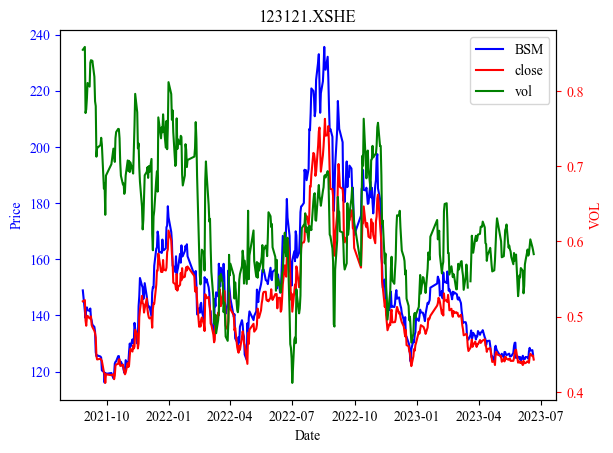

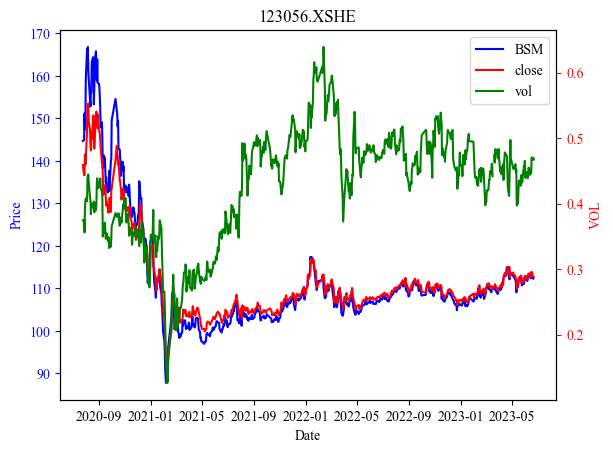

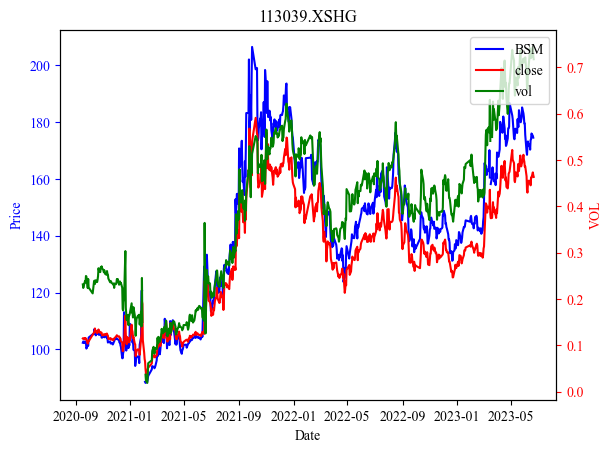

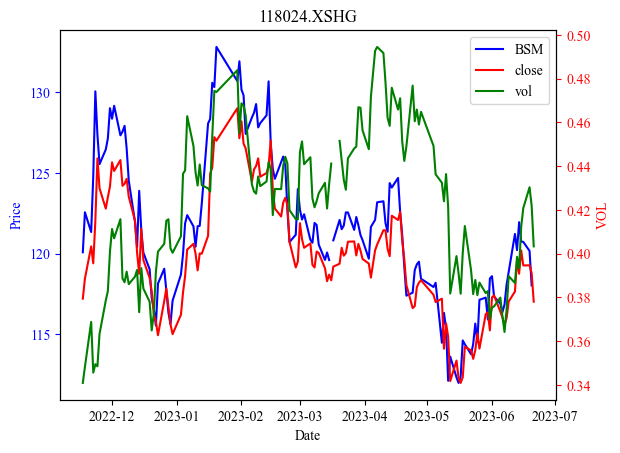

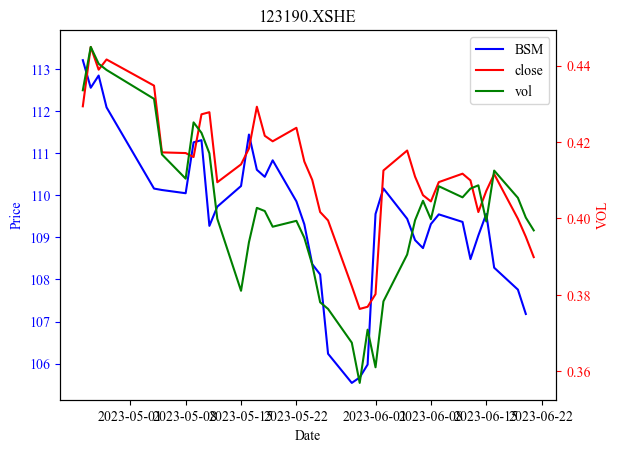

In [40]:
order_book_id_lis = list(set(df_call_Newton_IV['order_book_id']))
# plot of some examples
for i in range(0,5):
    order_book_id = order_book_id_lis[i]
    df_i = df_call_Newton_IV[df_call_Newton_IV['order_book_id']==order_book_id]
    plot_comparison(df_i,order_book_id,'BSM_nt_iv')

### Save data files

In [ ]:
df_call_RQ_IV.to_csv('df_call_RQ_IV','w')
df_call_Newton_IV.to_csv('df_call_Newton_IV.csv','w')
df_call_historic_vol.to_csv('df_call_historic_vol.csv','w')

## Single Factor Analysis

### NT_IV before 2022-05-01

<Figure size 1500x1200 with 0 Axes>

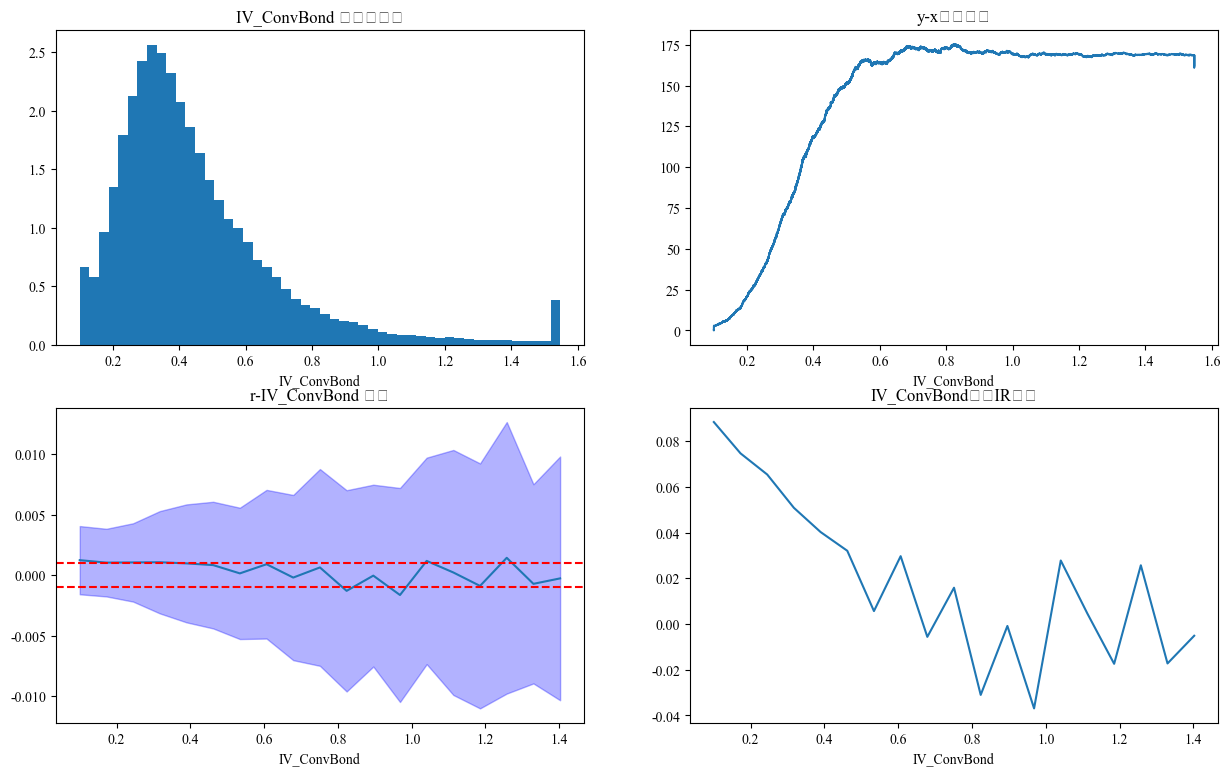

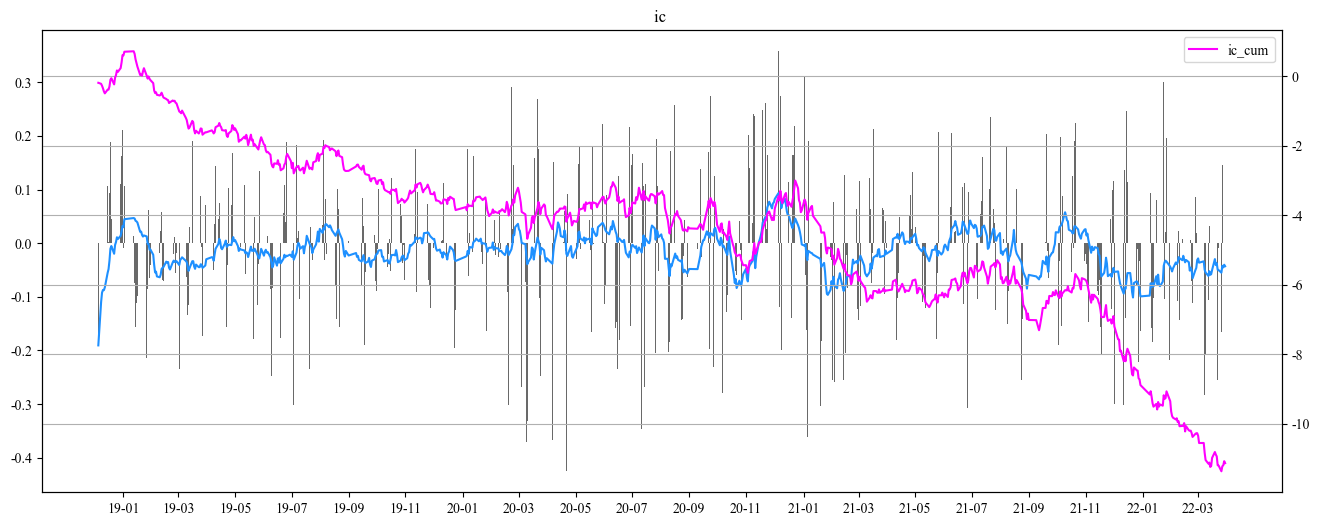

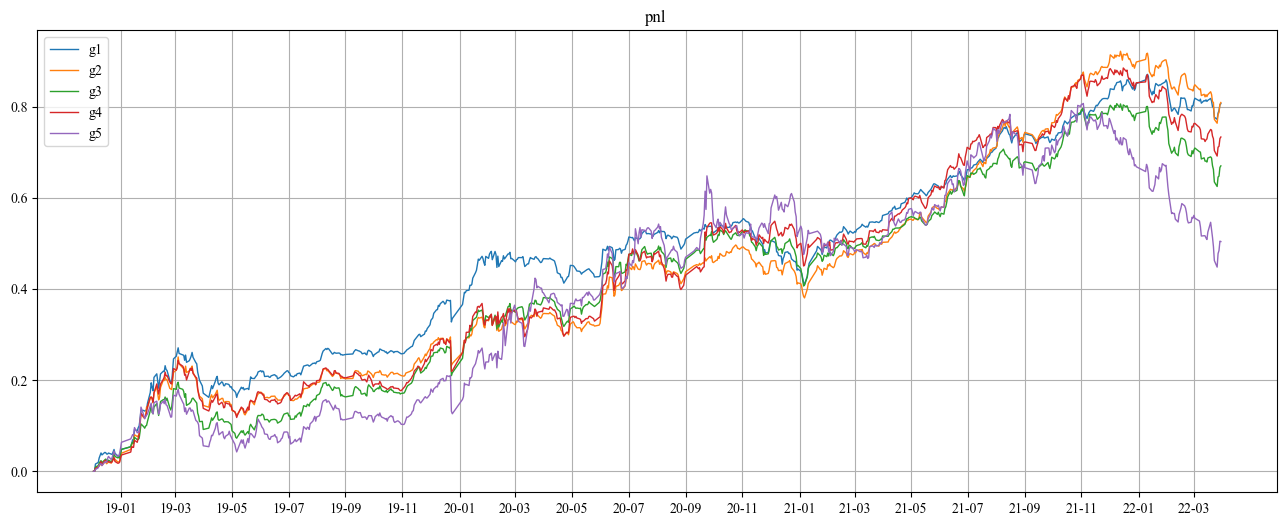

In [33]:
df = df_call_Newton_IV
df = df.sort_values(['order_book_id','date'])
data = df
# 构建因子 
# df['factor1'] = np.where(df.order_book_id == df.order_book_id.shift(20),df.close/df.close.shift(20)-1,np.nan)
factor = 'IV_ConvBond'

# 预测收益
df['r'] = np.where(df.order_book_id == df.order_book_id.shift(2),df.open.shift(-2)/df.open.shift(-1)-1,0)
r= 'r'
data = df[['date','order_book_id','r',factor]].dropna()
data = data[~np.isinf(data['r'])]
data = data[data['date']<'2022-05-01']
data['date'] = data['date'].apply(lambda x:str(x)[:10])
look(data,factor,r,thresh=0.01, div_num=20)
analyse_ic(data,factor,r)    
analyse_group(data,factor,r,num_group=5)

### IMPLIEDVOL before 2022-05-01

<IPython.core.display.Javascript object>

<Figure size 1500x1200 with 0 Axes>

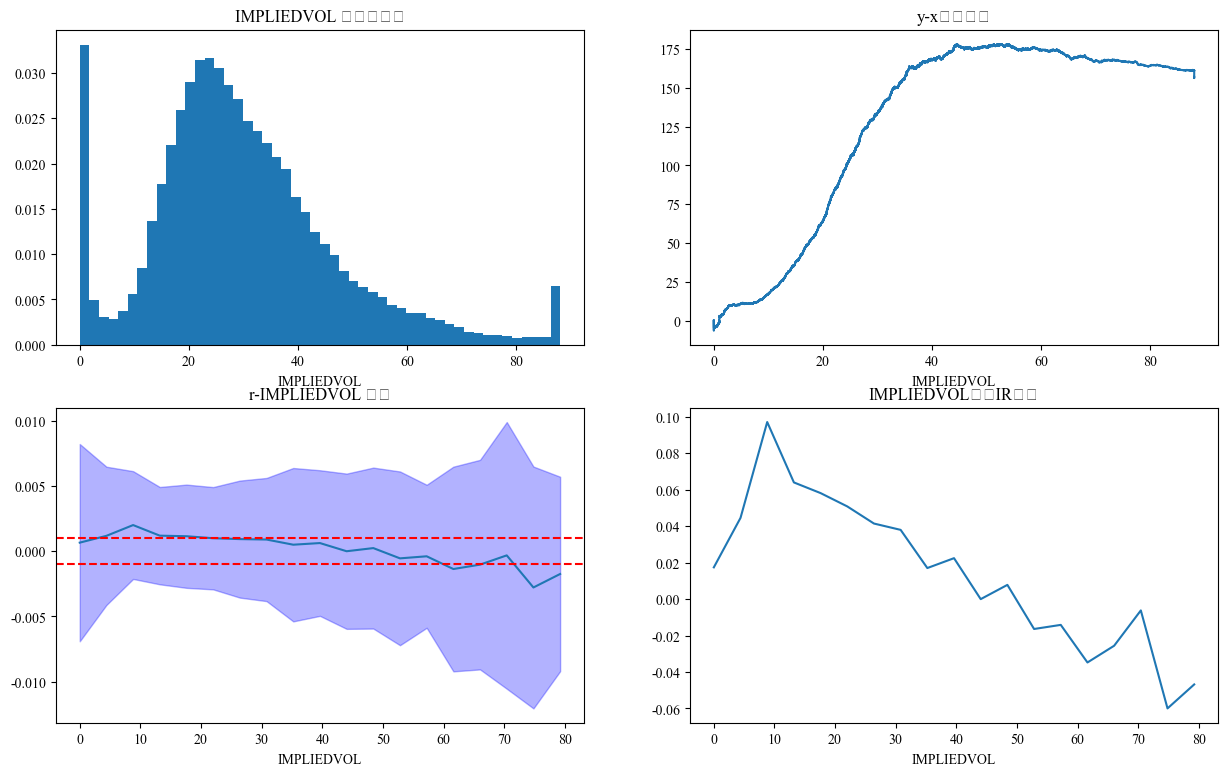

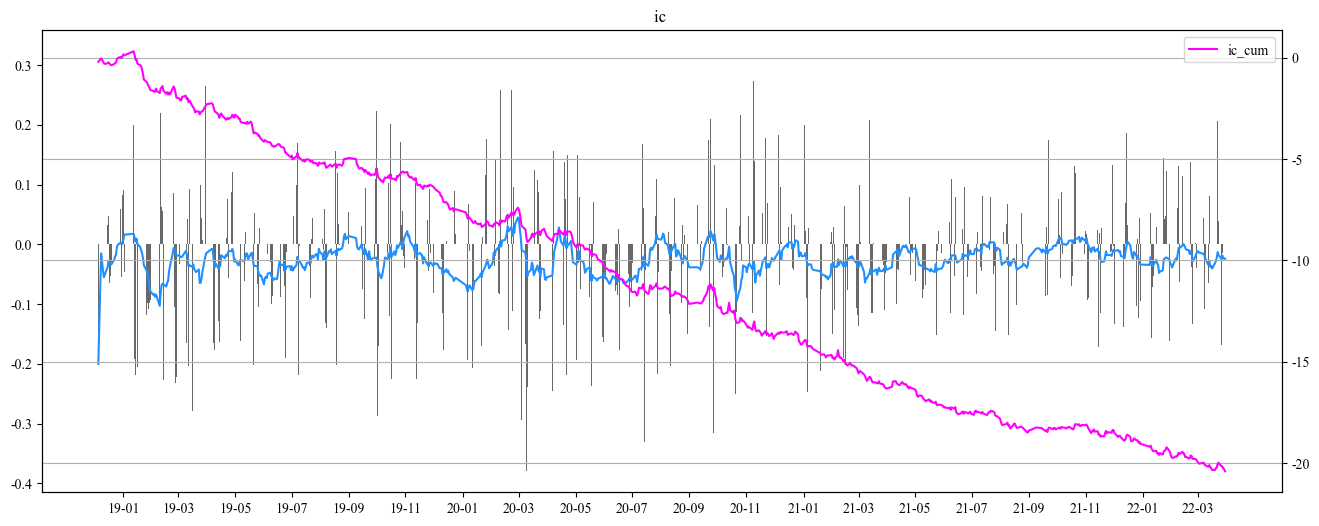

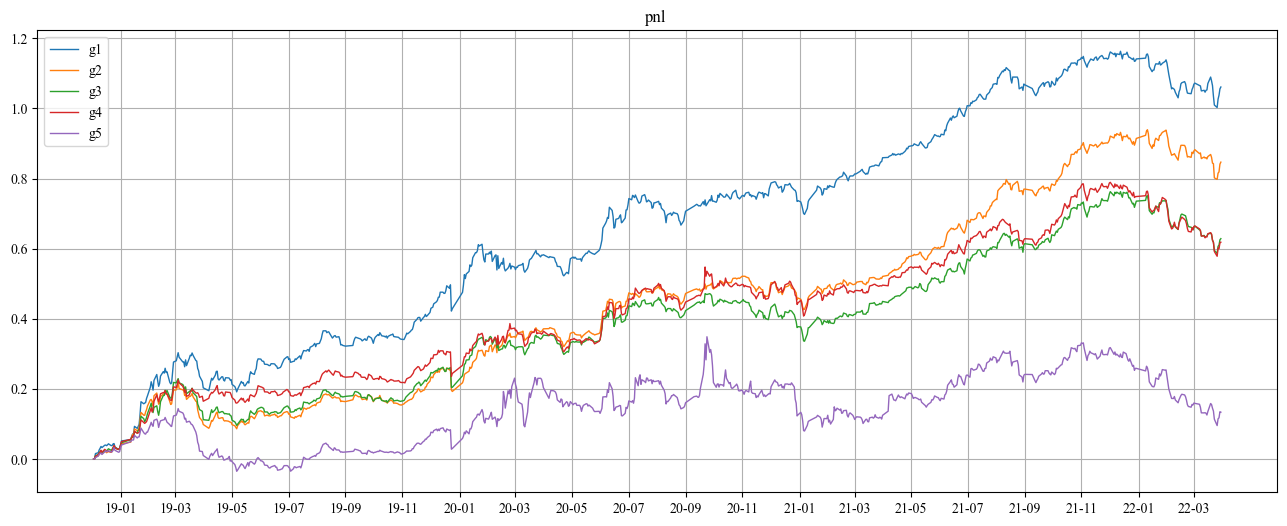

In [31]:
df = df_call_historic_vol
mpl.rcParams['font.family'] = 'Times New Roman'
df = df.sort_values(['order_book_id','date'])
data = df
# 构建因子 
# df['factor1'] = np.where(df.order_book_id == df.order_book_id.shift(20),df.close/df.close.shift(20)-1,np.nan)
factor = 'historic_vol_20'
factor = 'IMPLIEDVOL'
# 预测收益
df['r'] = np.where(df.order_book_id == df.order_book_id.shift(2),df.open.shift(-2)/df.open.shift(-1)-1,0)
r= 'r'
data = df[['date','order_book_id','r',factor]].dropna()
data = data[~np.isinf(data['r'])]
data = data[data['date']<'2022-05-01']
data['date'] = data['date'].apply(lambda x:str(x)[:10])
look(data,factor,r,thresh=0.01, div_num=20)
analyse_ic(data,factor,r)    
analyse_group(data,factor,r,num_group=5)

### NT_IV

<Figure size 1500x1200 with 0 Axes>

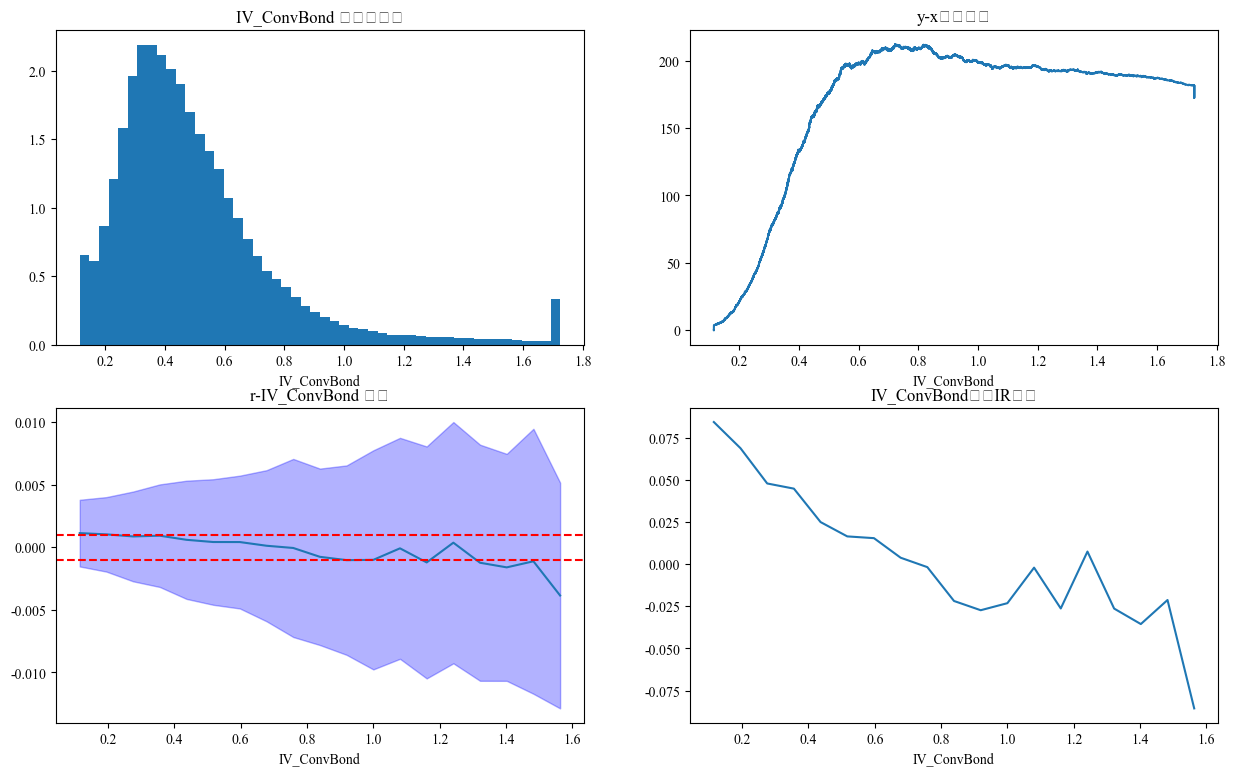

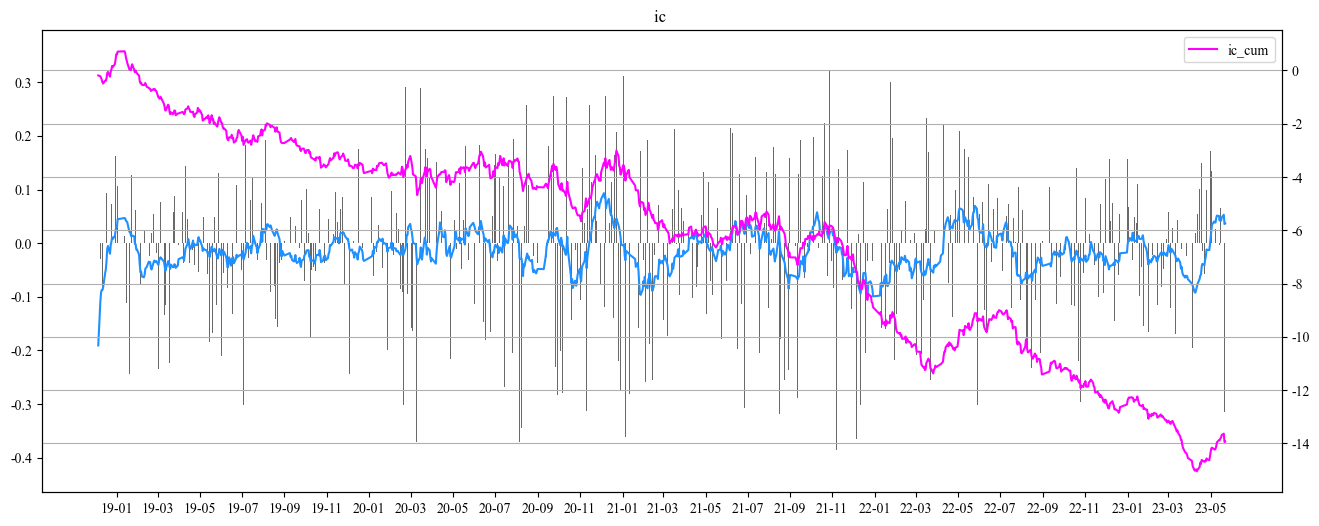

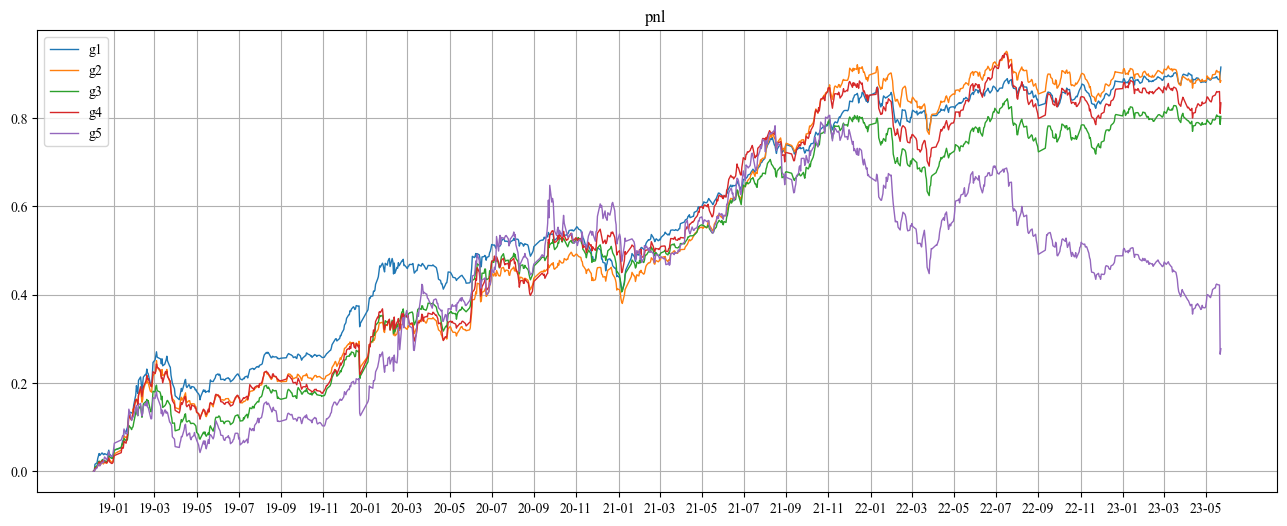

In [34]:
df = df_call_Newton_IV
df = df.sort_values(['order_book_id','date'])
data = df
# 构建因子 
# df['factor1'] = np.where(df.order_book_id == df.order_book_id.shift(20),df.close/df.close.shift(20)-1,np.nan)
factor = 'IV_ConvBond'

# 预测收益
df['r'] = np.where(df.order_book_id == df.order_book_id.shift(2),df.open.shift(-2)/df.open.shift(-1)-1,0)
r= 'r'
data = df[['date','order_book_id','r',factor]].dropna()
data = data[~np.isinf(data['r'])]
data['date'] = data['date'].apply(lambda x:str(x)[:10])
look(data,factor,r,thresh=0.01, div_num=20)
analyse_ic(data,factor,r)    
analyse_group(data,factor,r,num_group=5)

### his_vol_20

<Figure size 1500x1200 with 0 Axes>

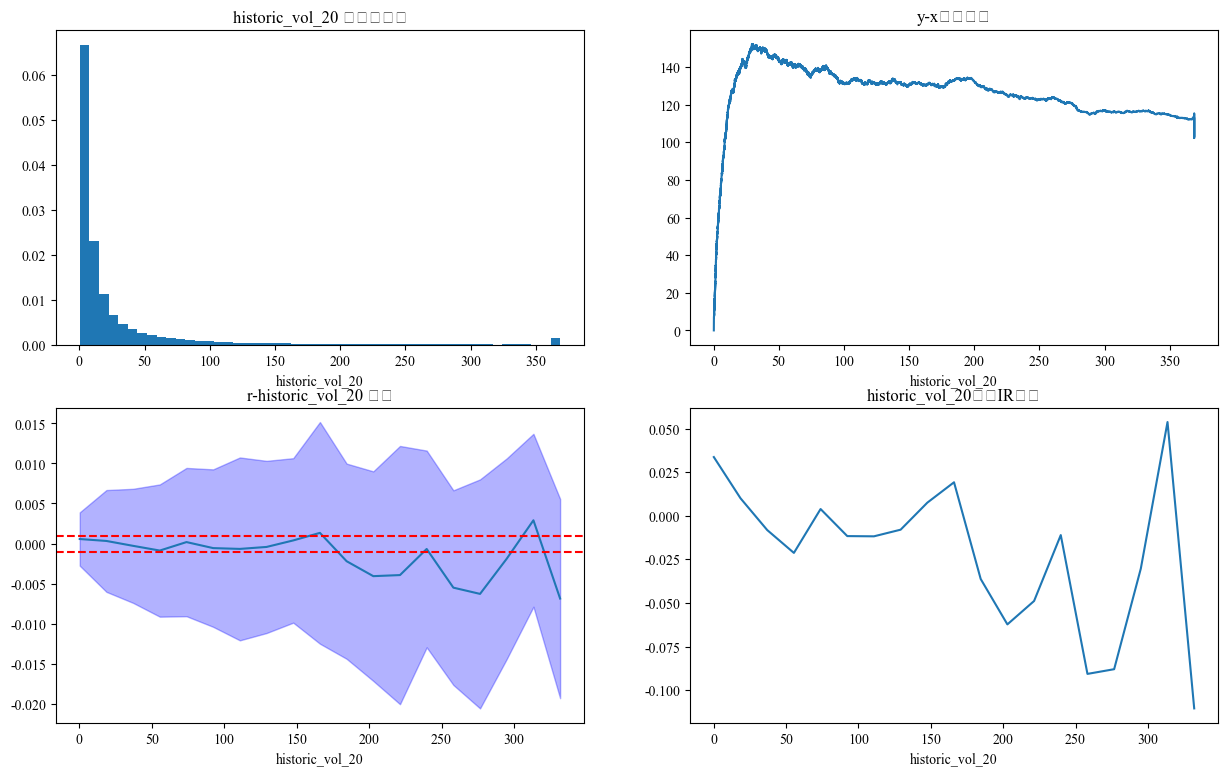

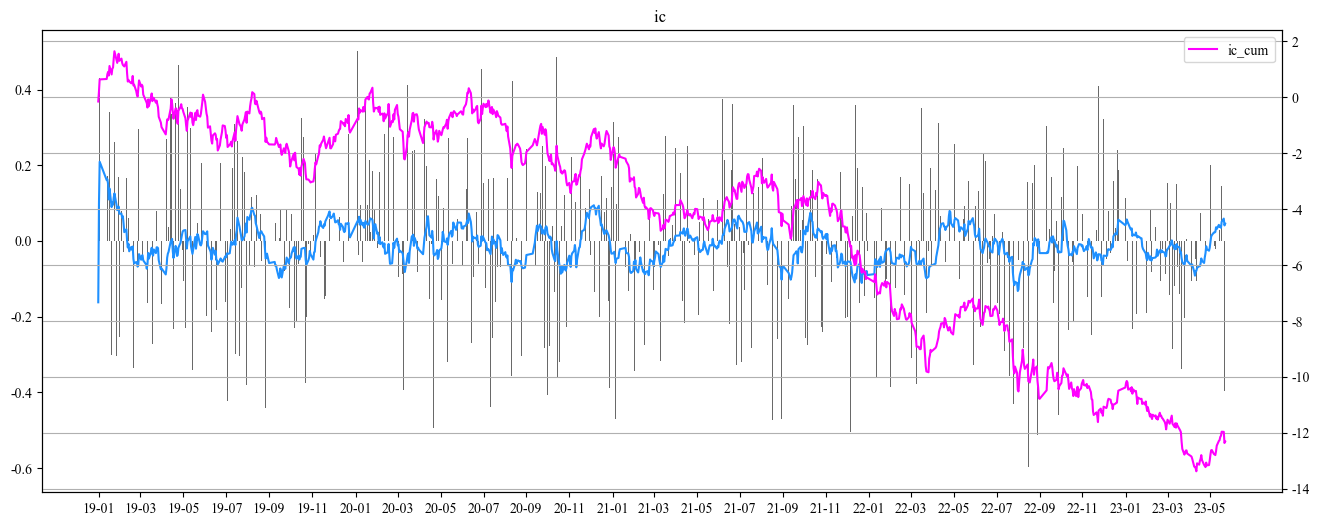

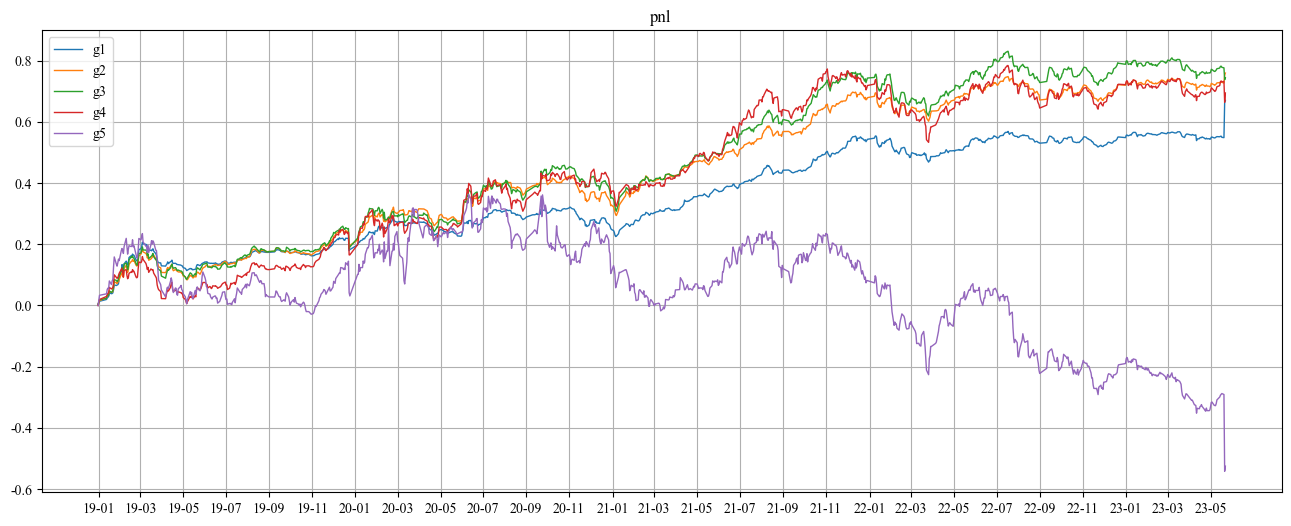

In [80]:
df = df_call_historic_vol
df = df.sort_values(['order_book_id','date'])
data = df
# 构建因子 
# df['factor1'] = np.where(df.order_book_id == df.order_book_id.shift(20),df.close/df.close.shift(20)-1,np.nan)
factor = 'historic_vol_20'

# 预测收益
df['r'] = np.where(df.order_book_id == df.order_book_id.shift(2),df.open.shift(-2)/df.open.shift(-1)-1,0)
r= 'r'
data = df[['date','order_book_id','r',factor]].dropna()
data = data[~np.isinf(data['r'])]
data['date'] = data['date'].apply(lambda x:str(x)[:10])
look(data,factor,r,thresh=0.01, div_num=20)
analyse_ic(data,factor,r)    
analyse_group(data,factor,r,num_group=5)

### his_vol_60

<Figure size 1500x1200 with 0 Axes>

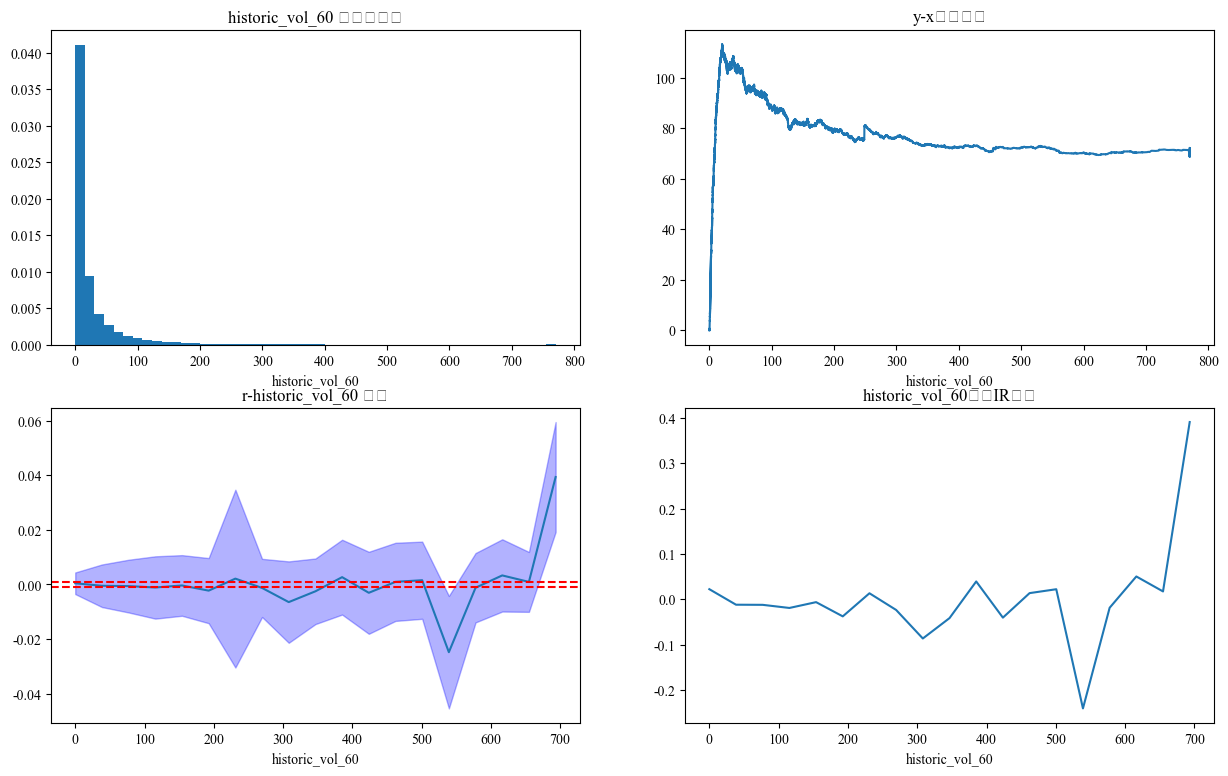

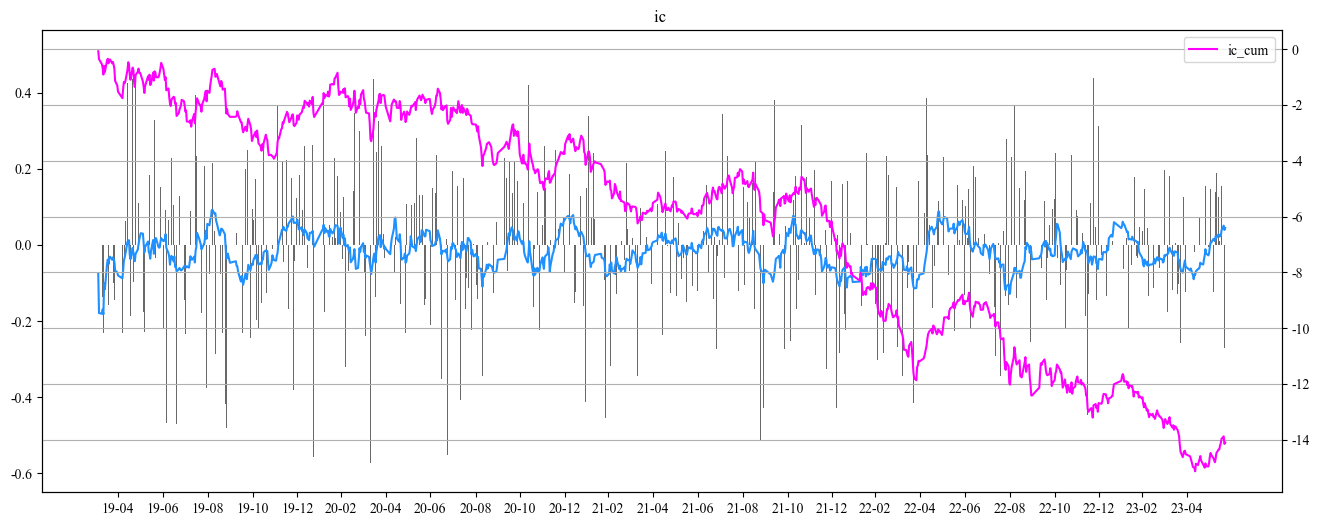

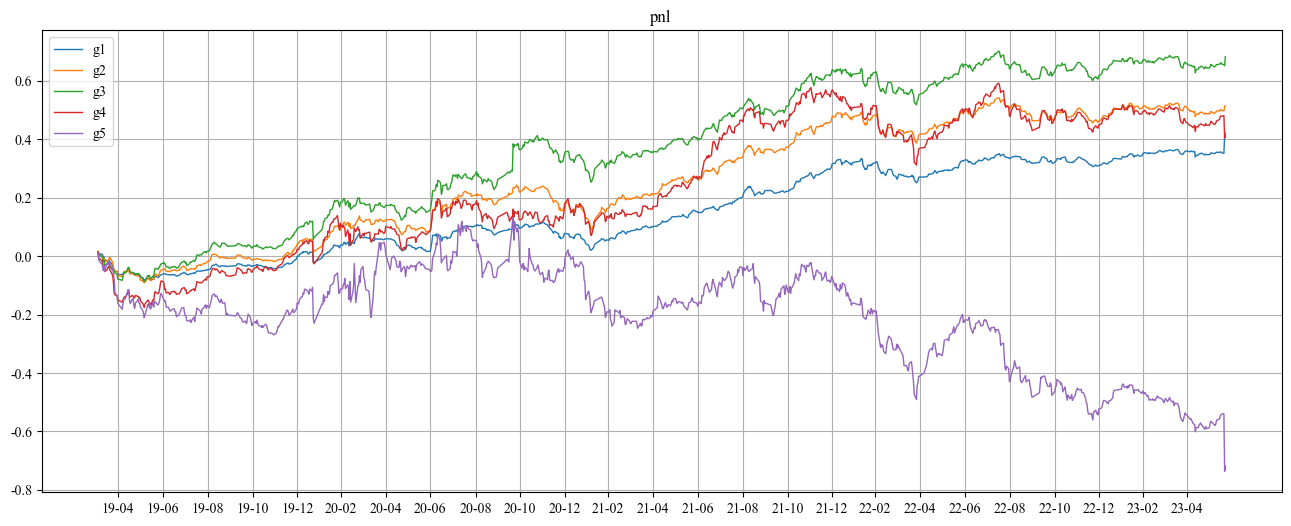

In [84]:
df = df_call_historic_vol
df = df.sort_values(['order_book_id','date'])
data = df
# 构建因子 
# df['factor1'] = np.where(df.order_book_id == df.order_book_id.shift(20),df.close/df.close.shift(20)-1,np.nan)
factor = 'historic_vol_60'

# 预测收益
df['r'] = np.where(df.order_book_id == df.order_book_id.shift(2),df.open.shift(-2)/df.open.shift(-1)-1,0)
r= 'r'
data = df[['date','order_book_id','r',factor]].dropna()
data = data[~np.isinf(data['r'])]
data['date'] = data['date'].apply(lambda x:str(x)[:10])
look(data,factor,r,thresh=0.001, div_num=20)
analyse_ic(data,factor,r)    
analyse_group(data,factor,r,num_group=5)

### NT_IV_pr_diff

<IPython.core.display.Javascript object>

<Figure size 1500x1200 with 0 Axes>

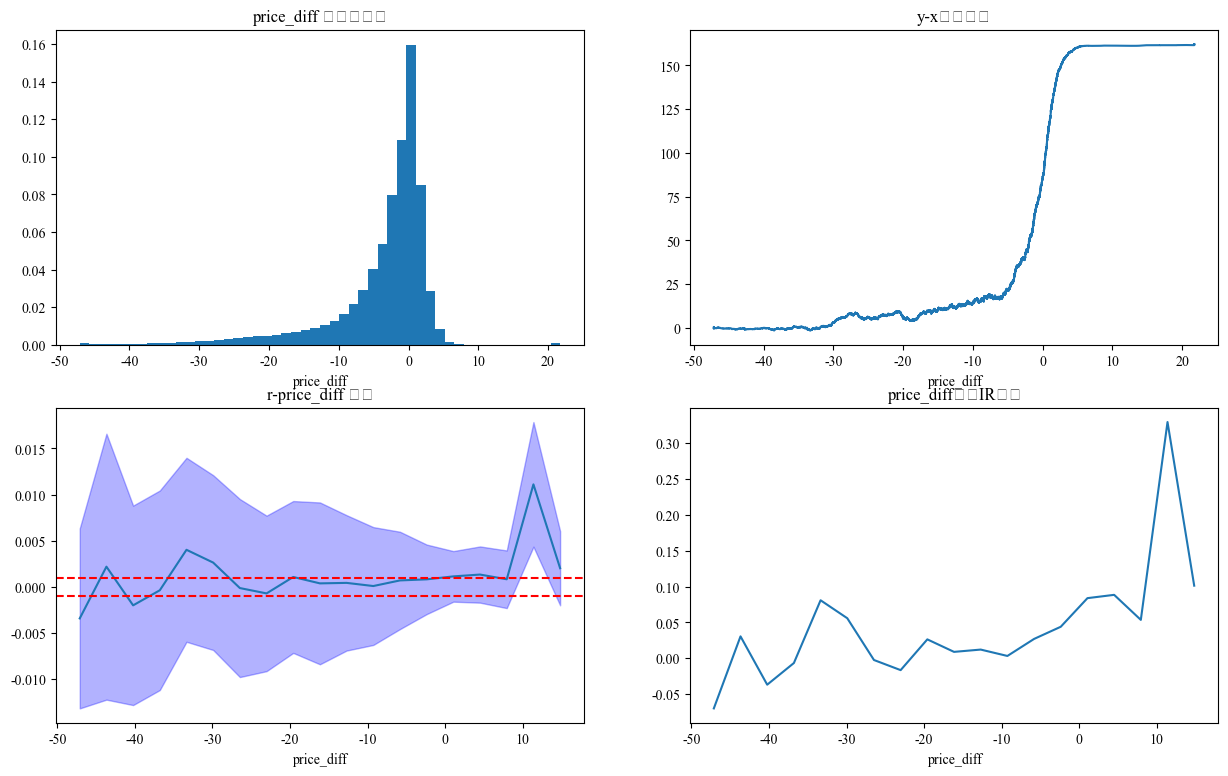

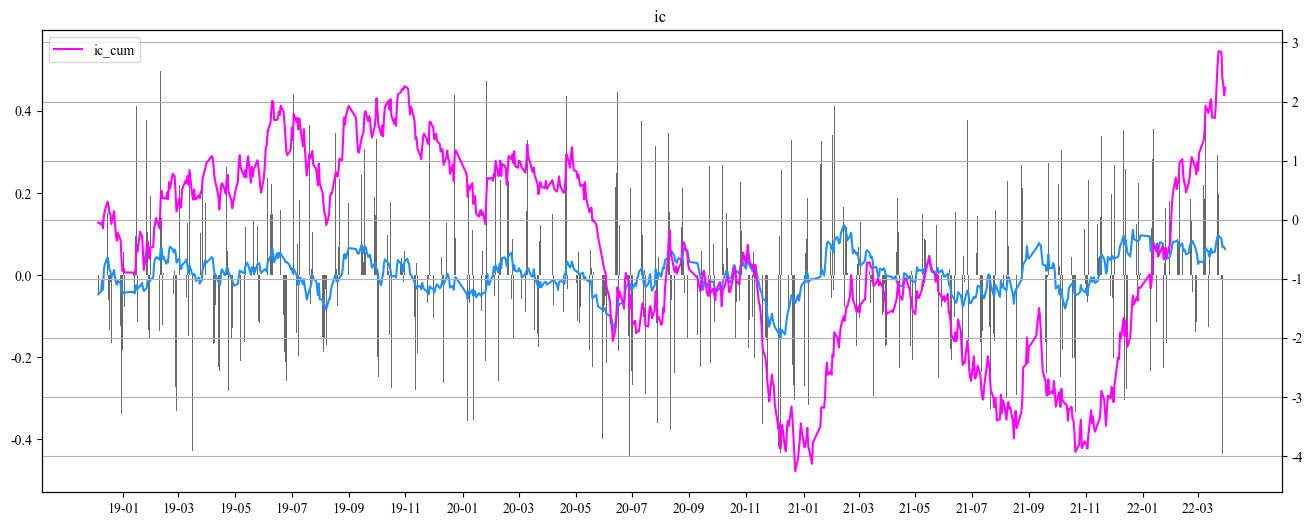

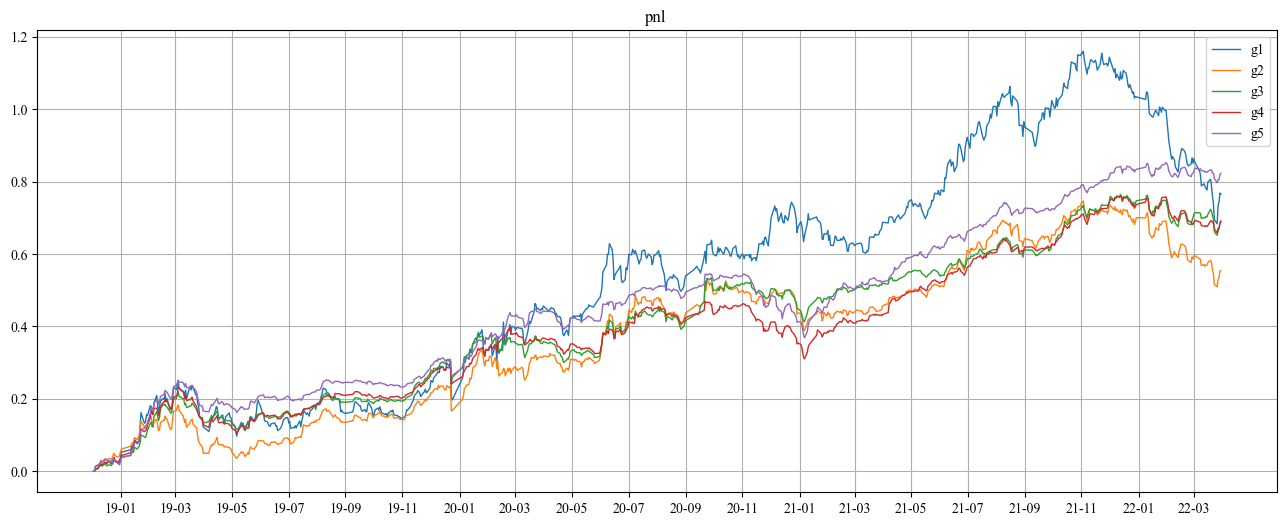

In [118]:
df_call_Newton_IV["price_diff"] = df_call_Newton_IV['close'] - df_call_Newton_IV['call_nt_iv'] - df_call_Newton_IV['pure_bond_value_1']
df = df_call_Newton_IV
mpl.rcParams['font.family'] = 'Times New Roman'
df = df.sort_values(['order_book_id','date'])
data = df
# 构建因子 
# df['factor1'] = np.where(df.order_book_id == df.order_book_id.shift(20),df.close/df.close.shift(20)-1,np.nan)
factor = 'price_diff'
# 预测收益
df['r'] = np.where(df.order_book_id == df.order_book_id.shift(2),df.open.shift(-2)/df.open.shift(-1)-1,0)
r= 'r'
data = df[['date','order_book_id','r',factor]].dropna()
data = data[~np.isinf(data['r'])]
data = data[data['date']<'2022-05-01']
data['date'] = data['date'].apply(lambda x:str(x)[:10])
look(data,factor,r,thresh=0.001, div_num=20)
analyse_ic(data,factor,r)    
analyse_group(data,factor,r,num_group=5)

### his_vol_20_pr_diff_d

<IPython.core.display.Javascript object>

<Figure size 1500x1200 with 0 Axes>

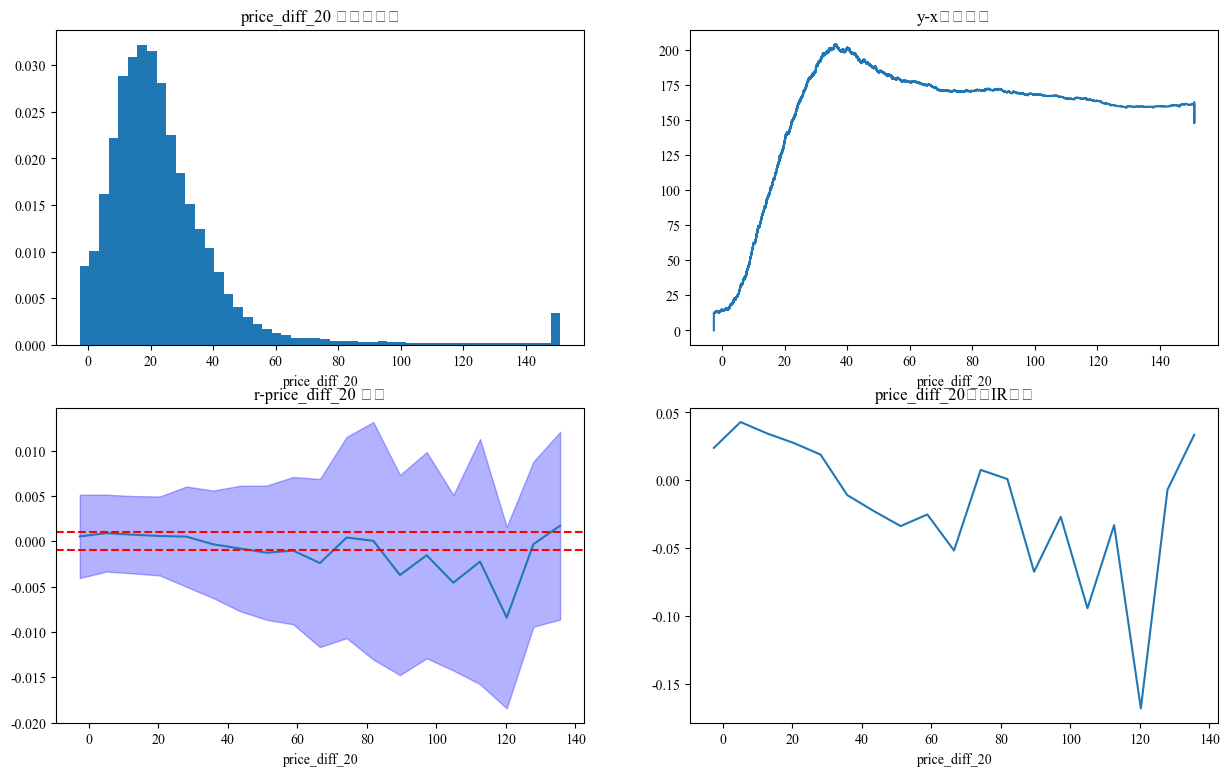

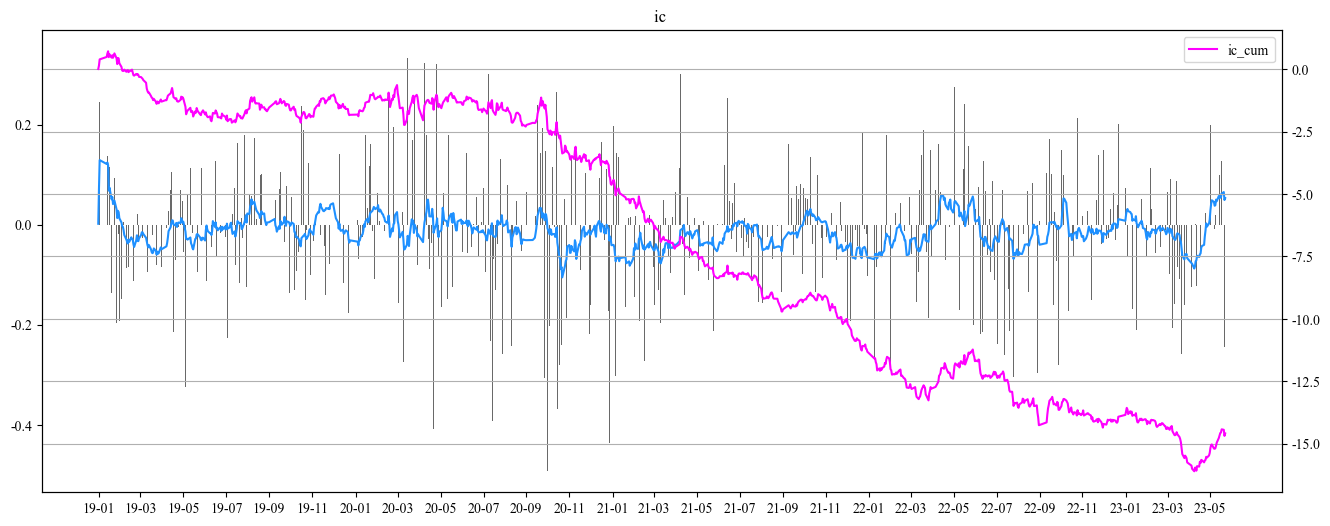

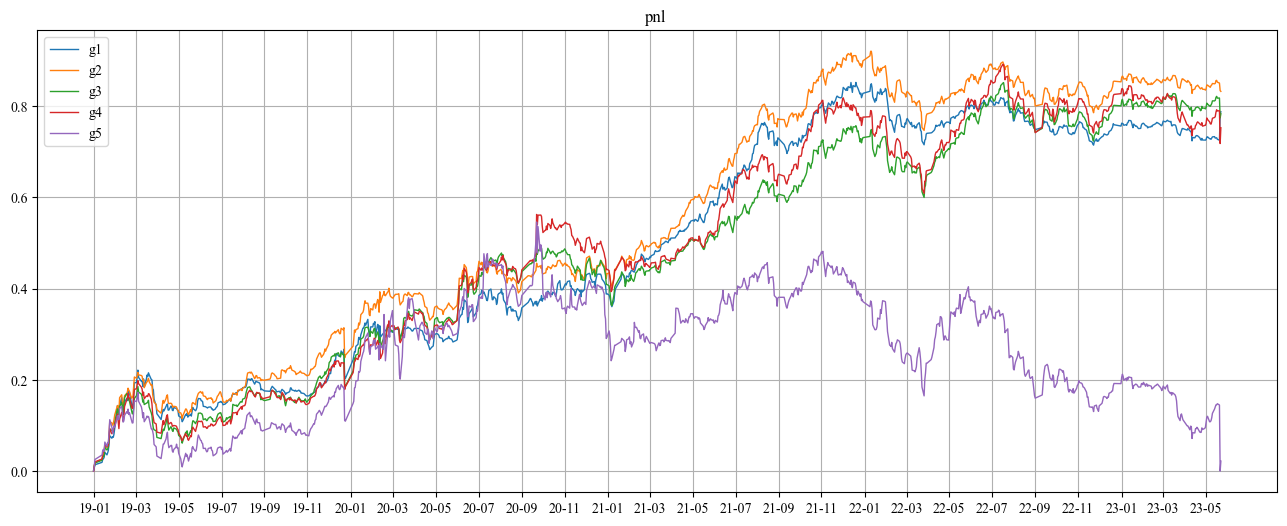

In [119]:
for x in [10,20,60,250]:
    df_call_historic_vol_d[f'price_diff_{x}'] = df_call_historic_vol_d['close'] - df_call_historic_vol_d[f'call_historic_vol_{x}'] - df_call_historic_vol_d['pure_bond_value_1']
df = df_call_historic_vol_d
mpl.rcParams['font.family'] = 'Times New Roman'
df = df.sort_values(['order_book_id','date'])
data = df
# 构建因子 
# df['factor1'] = np.where(df.order_book_id == df.order_book_id.shift(20),df.close/df.close.shift(20)-1,np.nan)
factor = 'price_diff_20'
# 预测收益
df['r'] = np.where(df.order_book_id == df.order_book_id.shift(2),df.open.shift(-2)/df.open.shift(-1)-1,0)
r= 'r'
data = df[['date','order_book_id','r',factor]].dropna()
data = data[~np.isinf(data['r'])]
data['date'] = data['date'].apply(lambda x:str(x)[:10])
look(data,factor,r,thresh=0.01, div_num=20)
analyse_ic(data,factor,r)    
analyse_group(data,factor,r,num_group=5)

### his_vol_60_pr_diff_d

<IPython.core.display.Javascript object>

<Figure size 1500x1200 with 0 Axes>

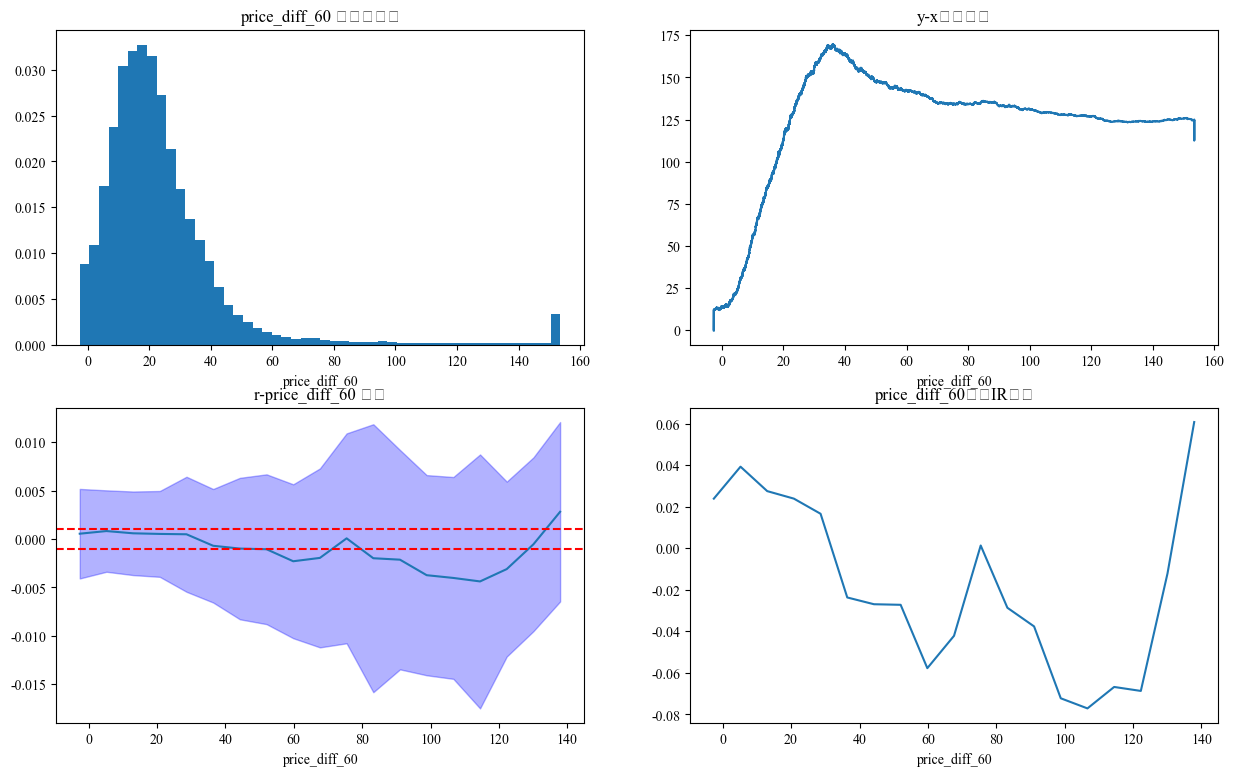

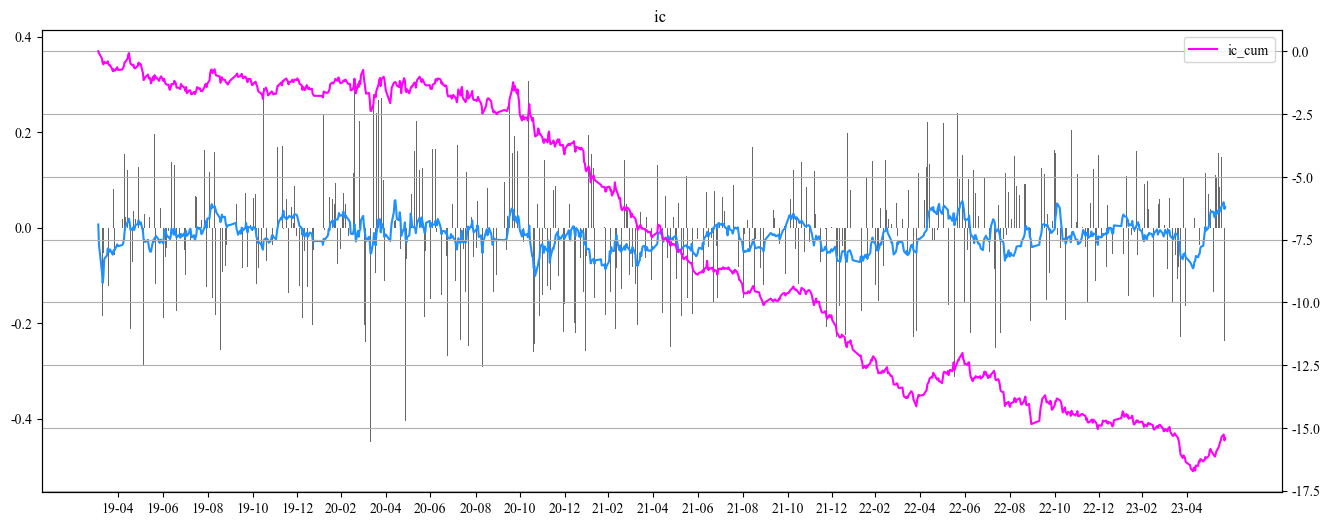

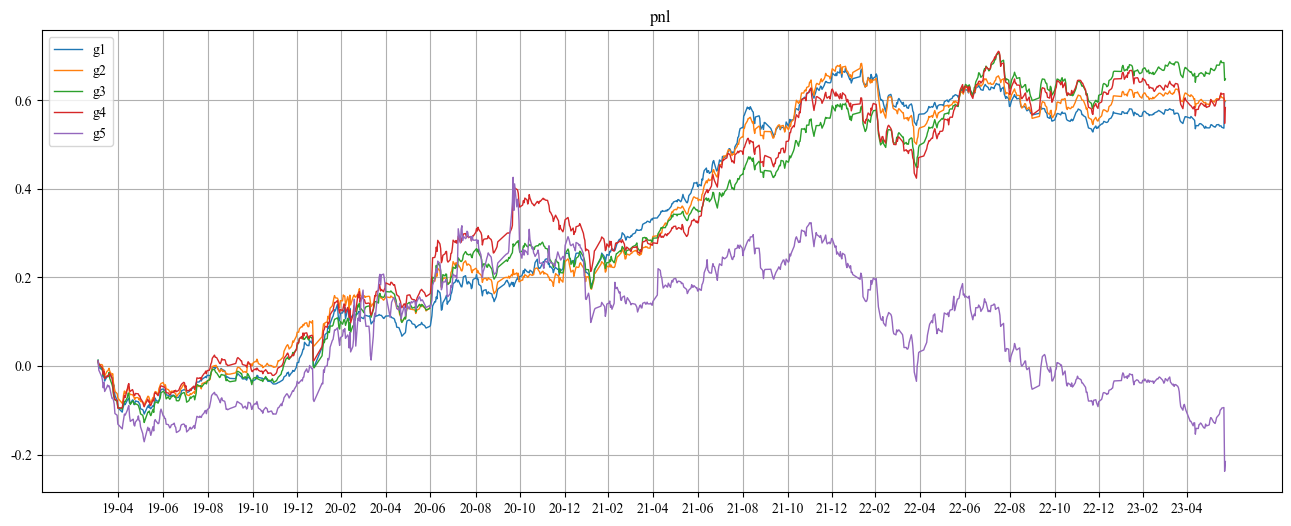

In [120]:
df = df_call_historic_vol_d
mpl.rcParams['font.family'] = 'Times New Roman'
df = df.sort_values(['order_book_id','date'])
data = df
# 构建因子 
# df['factor1'] = np.where(df.order_book_id == df.order_book_id.shift(20),df.close/df.close.shift(20)-1,np.nan)
factor = 'price_diff_60'
# 预测收益
df['r'] = np.where(df.order_book_id == df.order_book_id.shift(2),df.open.shift(-2)/df.open.shift(-1)-1,0)
r= 'r'
data = df[['date','order_book_id','r',factor]].dropna()
data = data[~np.isinf(data['r'])]
data['date'] = data['date'].apply(lambda x:str(x)[:10])
look(data,factor,r,thresh=0.01, div_num=20)
analyse_ic(data,factor,r)    
analyse_group(data,factor,r,num_group=5)

### his_vol_250_pr_diff_d

<IPython.core.display.Javascript object>

<Figure size 1500x1200 with 0 Axes>

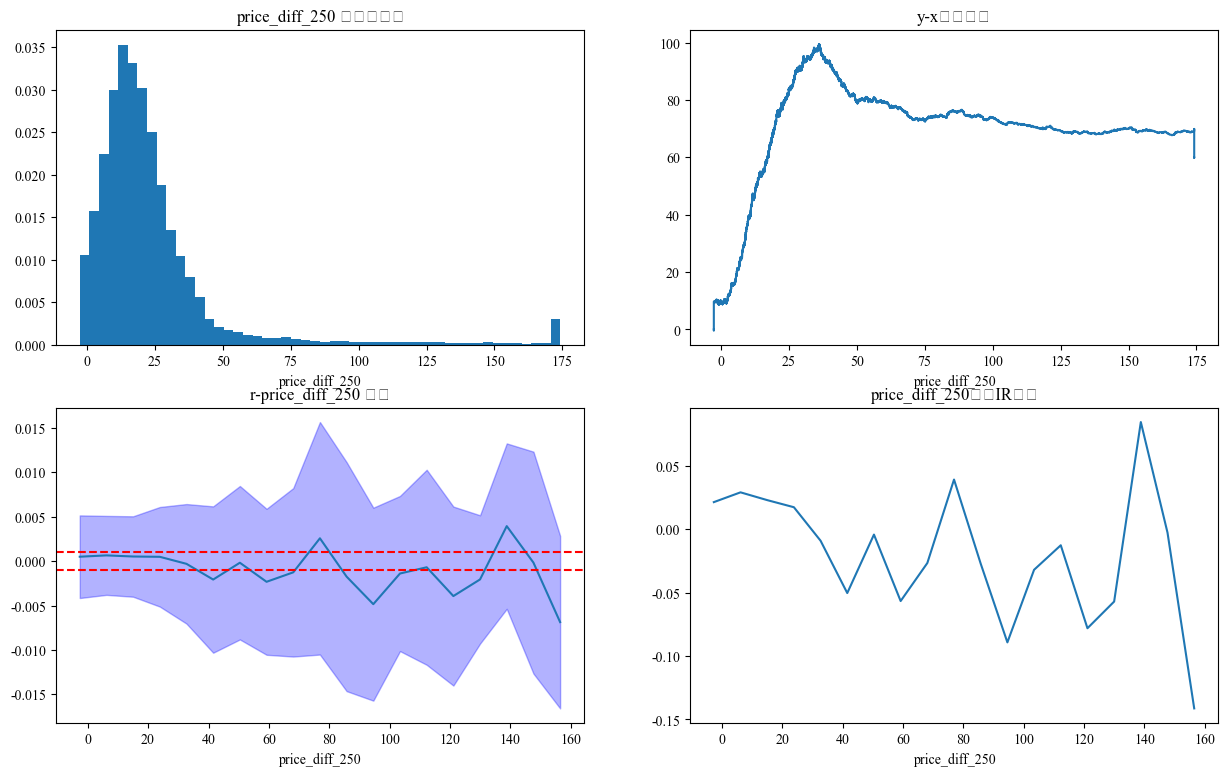

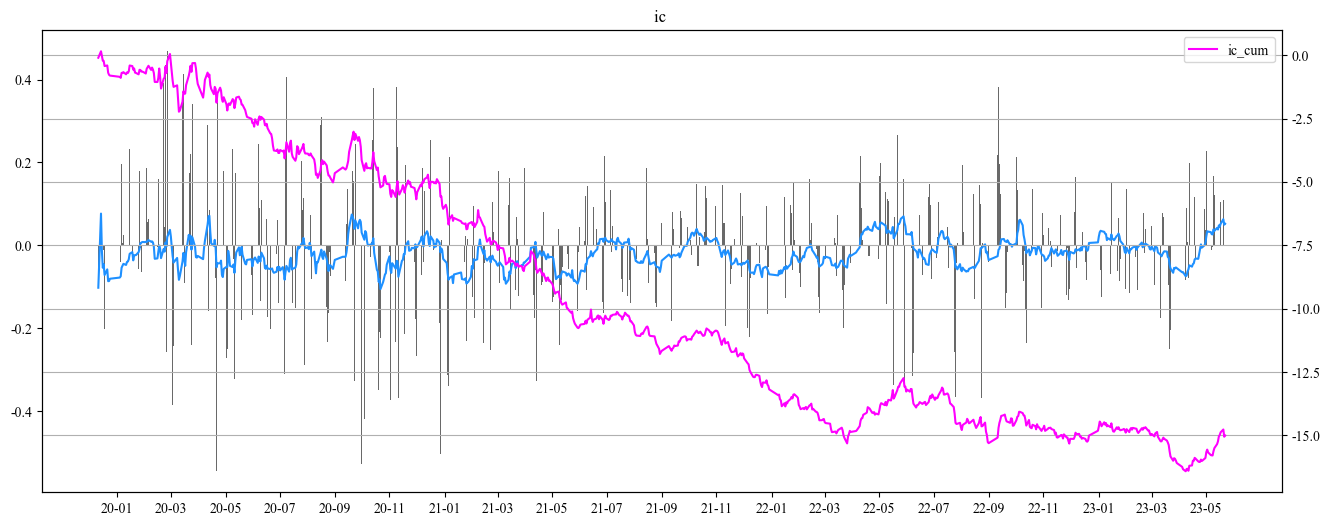

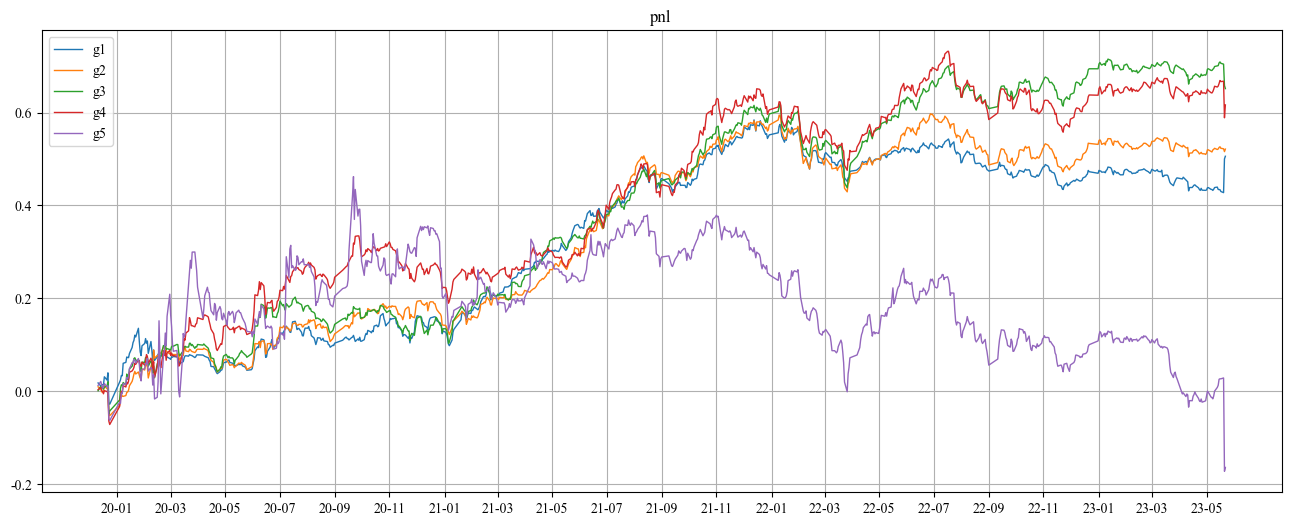

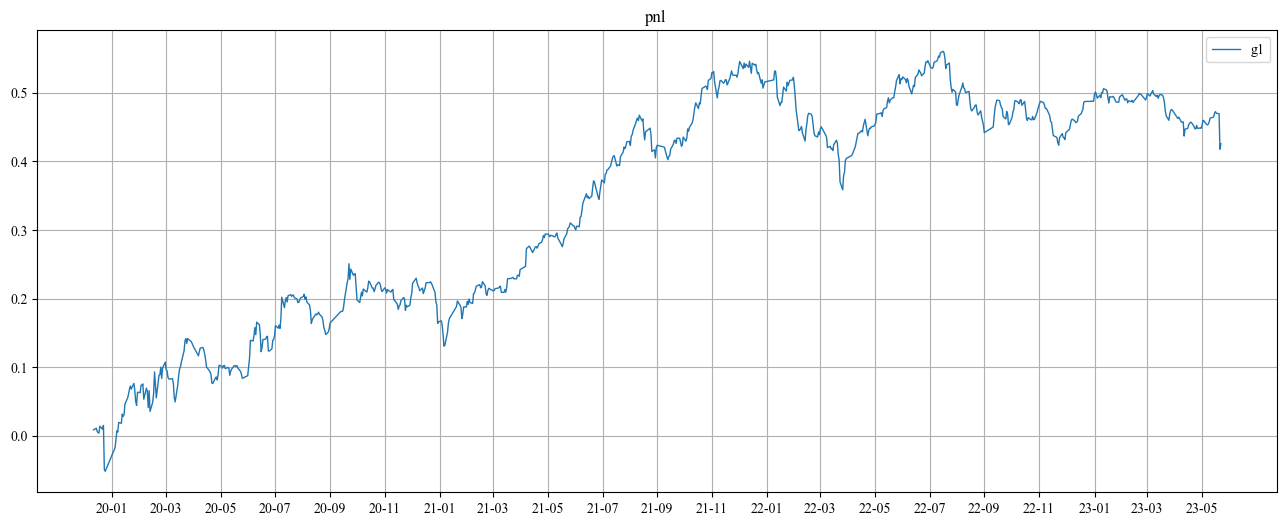

In [121]:
df = df_call_historic_vol_d
mpl.rcParams['font.family'] = 'Times New Roman'
df = df.sort_values(['order_book_id','date'])
data = df
# 构建因子 
# df['factor1'] = np.where(df.order_book_id == df.order_book_id.shift(20),df.close/df.close.shift(20)-1,np.nan)
factor = 'price_diff_250'
# 预测收益
df['r'] = np.where(df.order_book_id == df.order_book_id.shift(2),df.open.shift(-2)/df.open.shift(-1)-1,0)
r= 'r'
data = df[['date','order_book_id','r',factor]].dropna()
data = data[~np.isinf(data['r'])]
data['date'] = data['date'].apply(lambda x:str(x)[:10])
look(data,factor,r,thresh=0.01, div_num=20)
analyse_ic(data,factor,r)    
analyse_group(data,factor,r,num_group=5)
analyse_group(data,factor,r,num_group=1)

### his_vol_20_pr_diff_y

<IPython.core.display.Javascript object>

<Figure size 1500x1200 with 0 Axes>

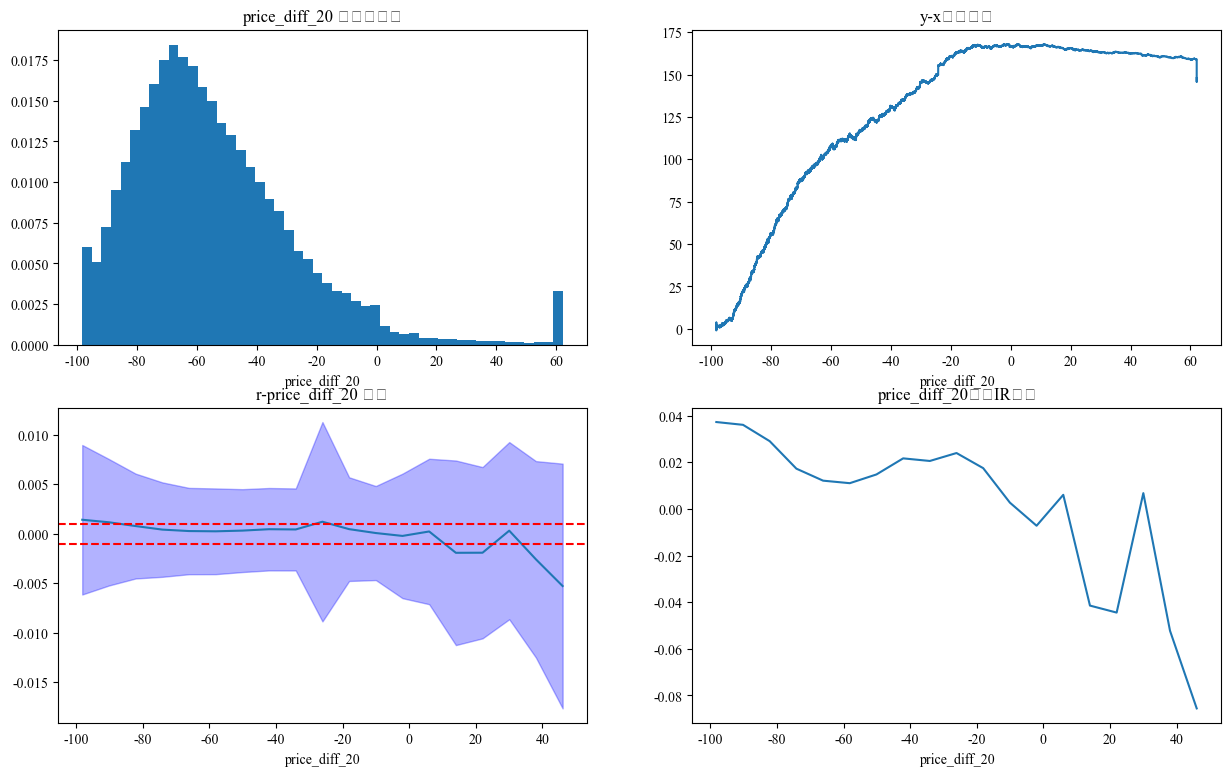

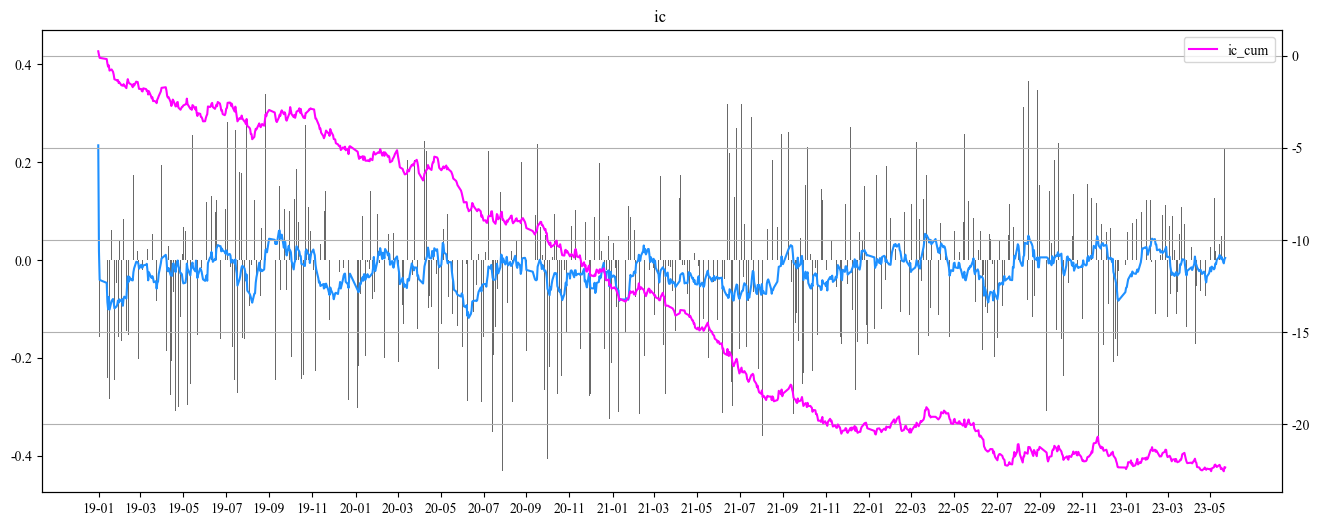

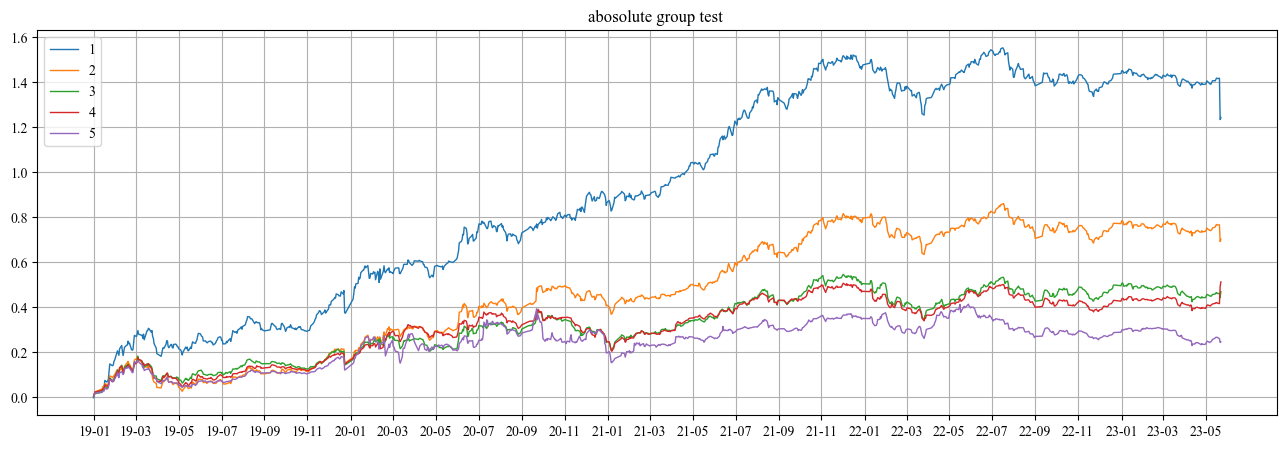

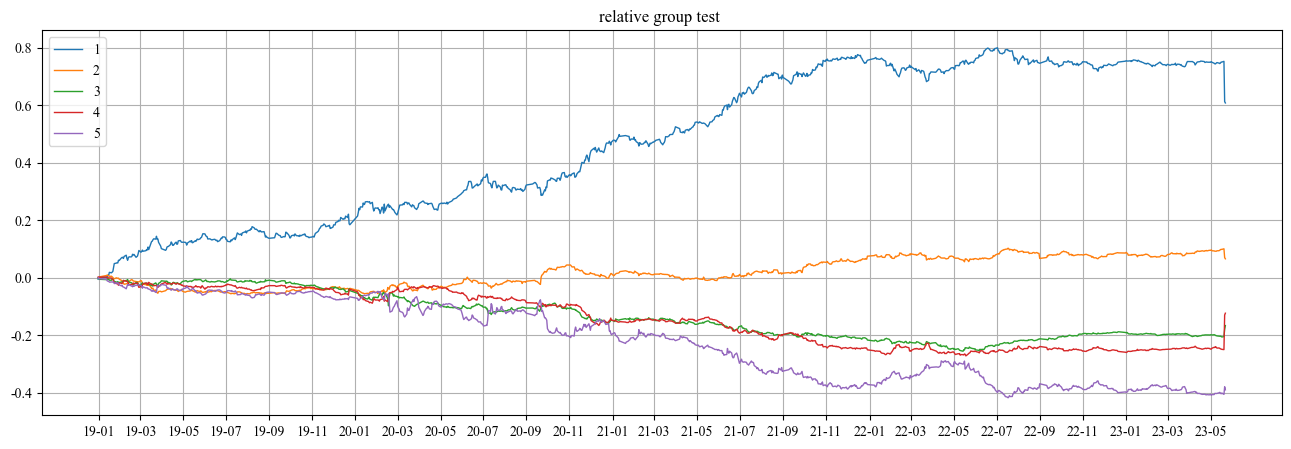

In [128]:
for x in [10,20,60,250]:
    df_call_historic_vol_y[f'price_diff_{x}'] = df_call_historic_vol_y['close'] - df_call_historic_vol_y[f'call_historic_vol_{x}'] - df_call_historic_vol_y['pure_bond_value_1']
df = df_call_historic_vol_y
mpl.rcParams['font.family'] = 'Times New Roman'
df = df.sort_values(['order_book_id','date'])
data = df
# 构建因子 
# df['factor1'] = np.where(df.order_book_id == df.order_book_id.shift(20),df.close/df.close.shift(20)-1,np.nan)
factor = 'price_diff_20'
# 预测收益
df['r'] = np.where(df.order_book_id == df.order_book_id.shift(2),df.open.shift(-2)/df.open.shift(-1)-1,0)
r= 'r'
data = df[['date','order_book_id','r',factor]].dropna()
data = data[~np.isinf(data['r'])]
data['date'] = data['date'].apply(lambda x:str(x)[:10])
look(data,factor,r,thresh=0.01, div_num=20)
analyse_ic(data,factor,r)    
analyse_group_new(data,factor,r,is_alpha=False,num_group=5)
analyse_group_new(data,factor,r,is_alpha=True,num_group=5)

In [131]:
df_call_historic_vol_y.to_csv('df_call_historic_vol_y.csv')

### his_vol_60_pr_diff_y

<IPython.core.display.Javascript object>

<Figure size 1500x1200 with 0 Axes>

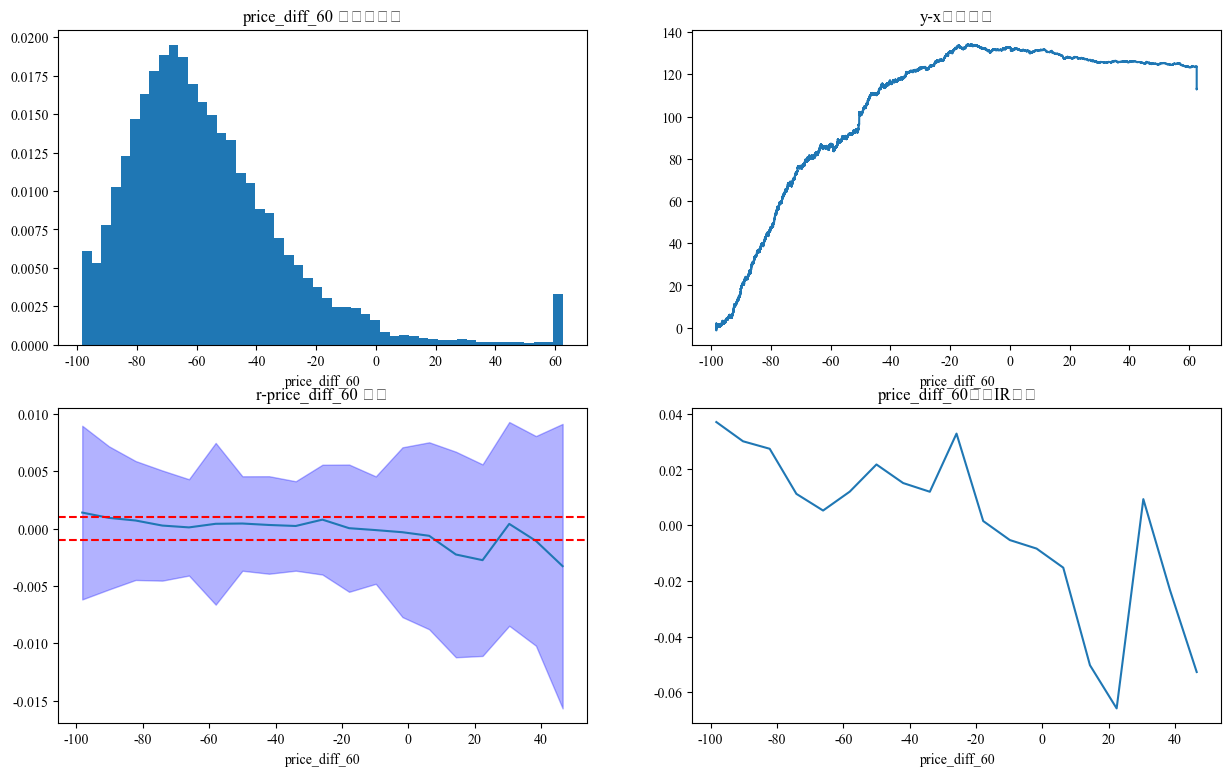

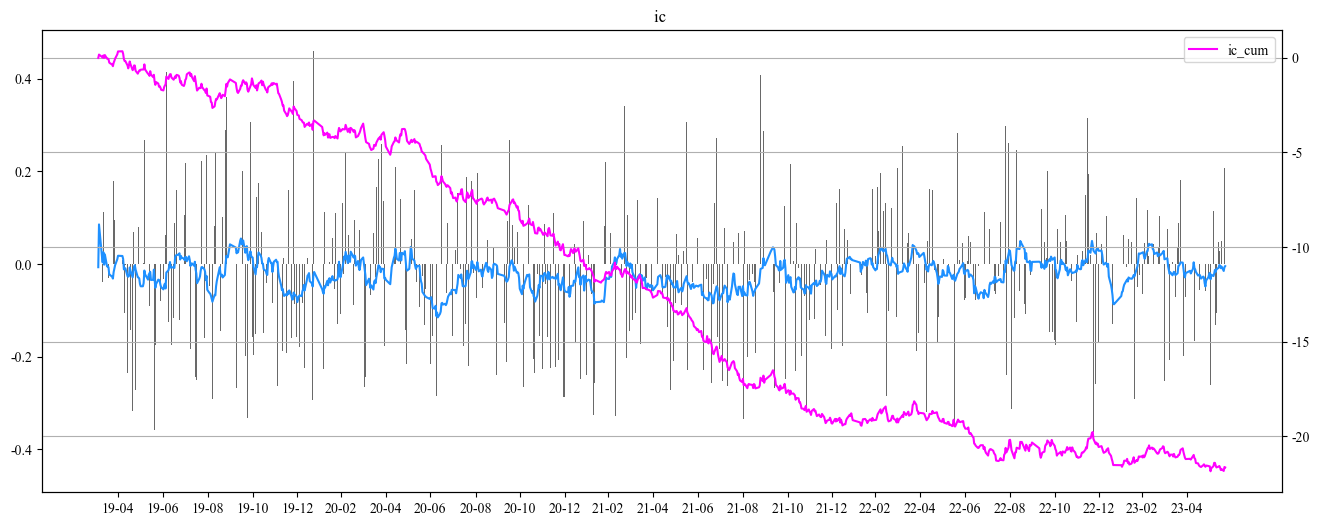

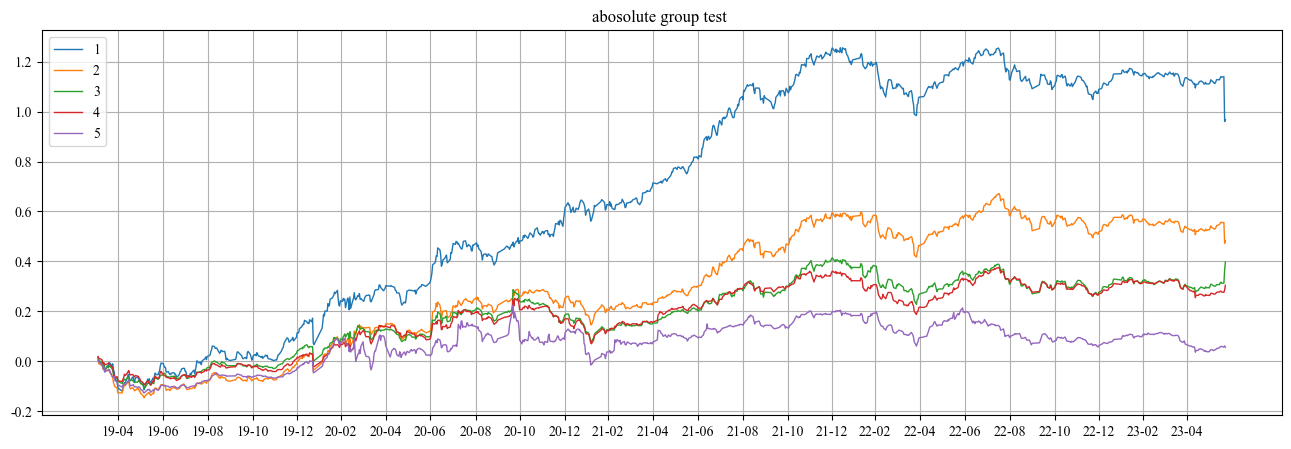

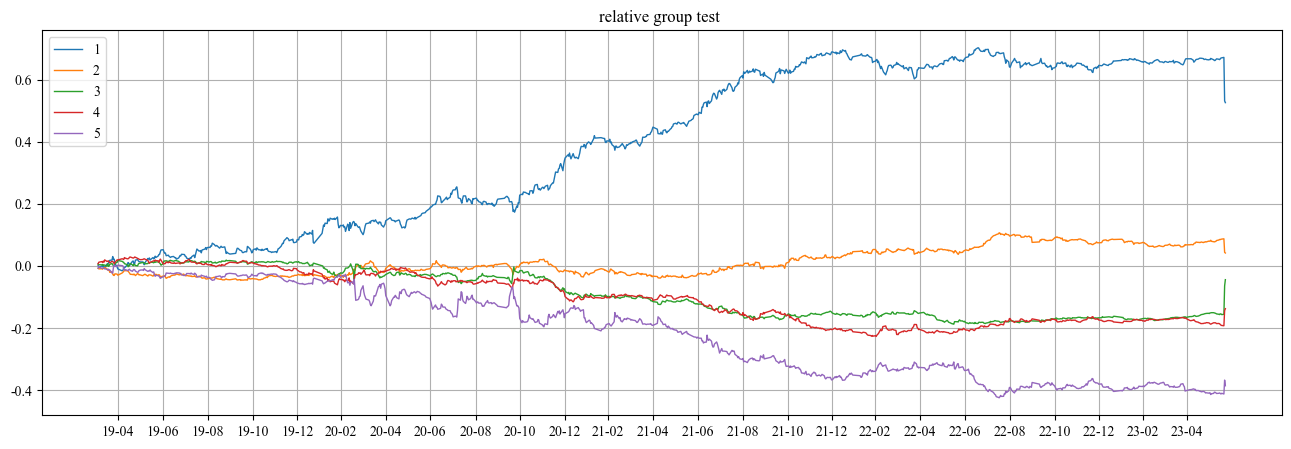

In [127]:
df = df_call_historic_vol_y
mpl.rcParams['font.family'] = 'Times New Roman'
df = df.sort_values(['order_book_id','date'])
data = df
# 构建因子 
# df['factor1'] = np.where(df.order_book_id == df.order_book_id.shift(20),df.close/df.close.shift(20)-1,np.nan)
factor = 'price_diff_60'
# 预测收益
df['r'] = np.where(df.order_book_id == df.order_book_id.shift(2),df.open.shift(-2)/df.open.shift(-1)-1,0)
r= 'r'
data = df[['date','order_book_id','r',factor]].dropna()
data = data[~np.isinf(data['r'])]
data['date'] = data['date'].apply(lambda x:str(x)[:10])
look(data,factor,r,thresh=0.01, div_num=20)
analyse_ic(data,factor,r)    
analyse_group_new(data,factor,r,is_alpha=False,num_group=5)
analyse_group_new(data,factor,r,is_alpha=True,num_group=5)
# analyse_group_new(data,factor,y,is_alpha=False,num_group=5,figsize=(16,5))

### his_vol_250_pr_diff_y

<IPython.core.display.Javascript object>

<Figure size 1500x1200 with 0 Axes>

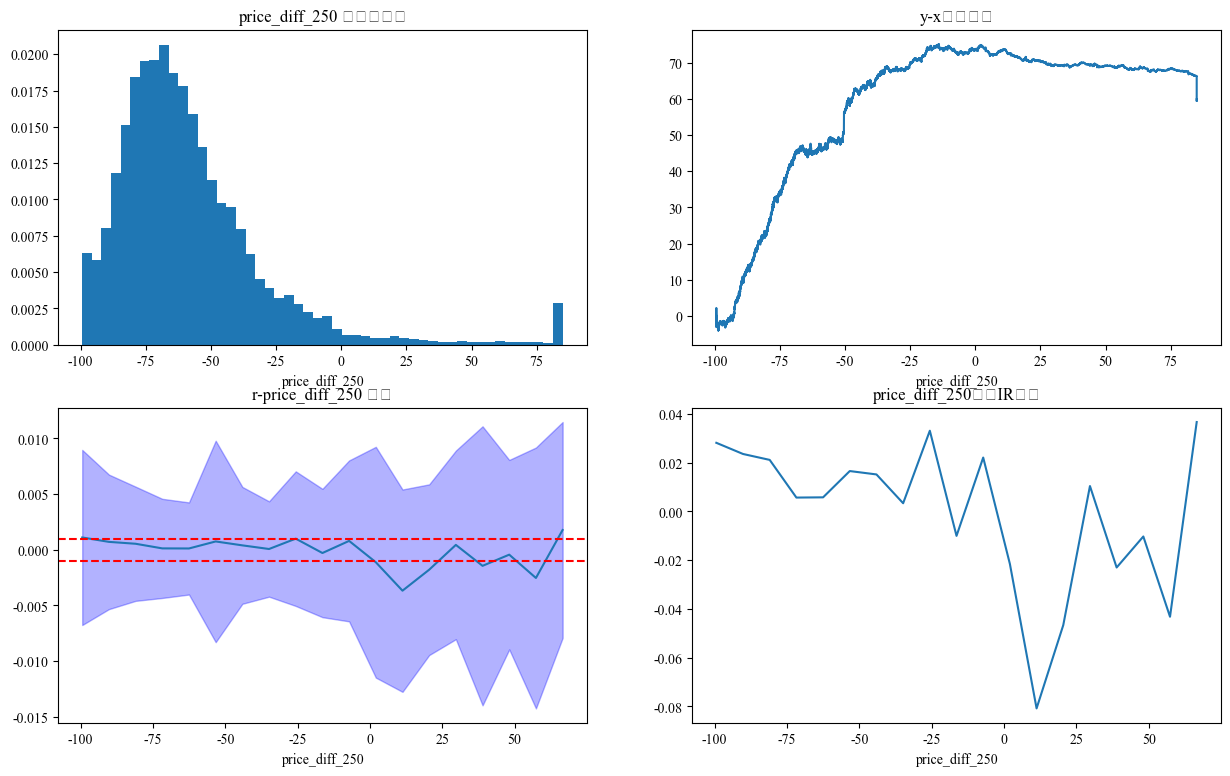

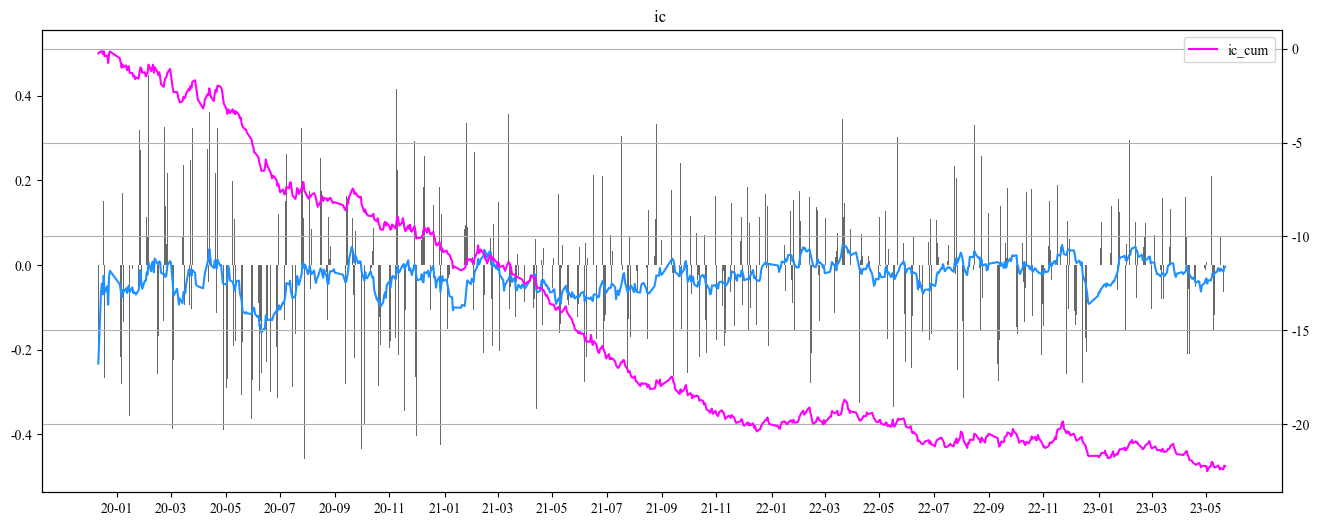

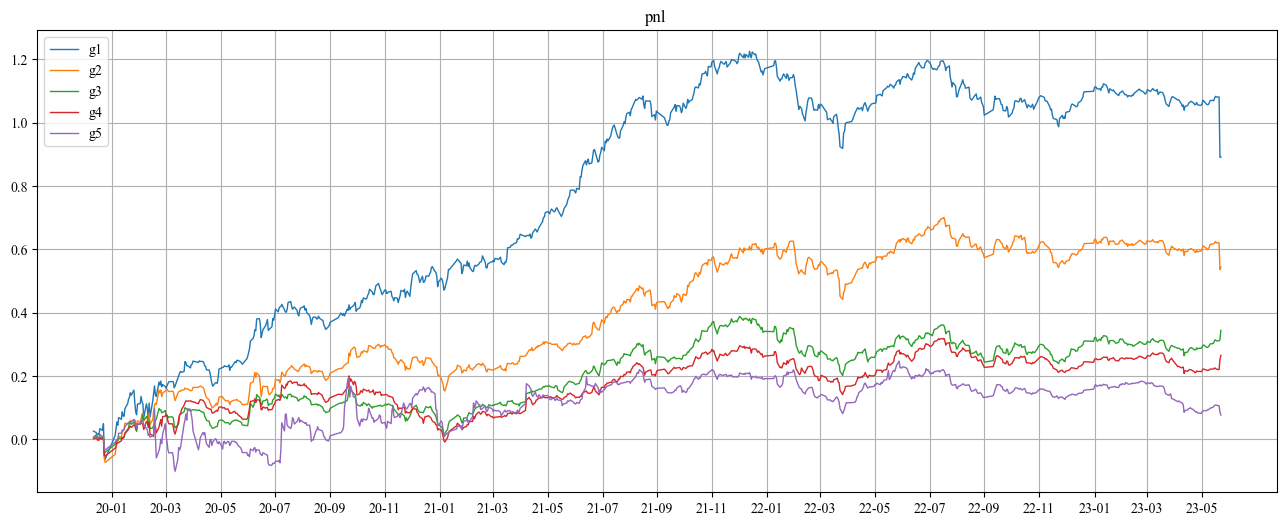

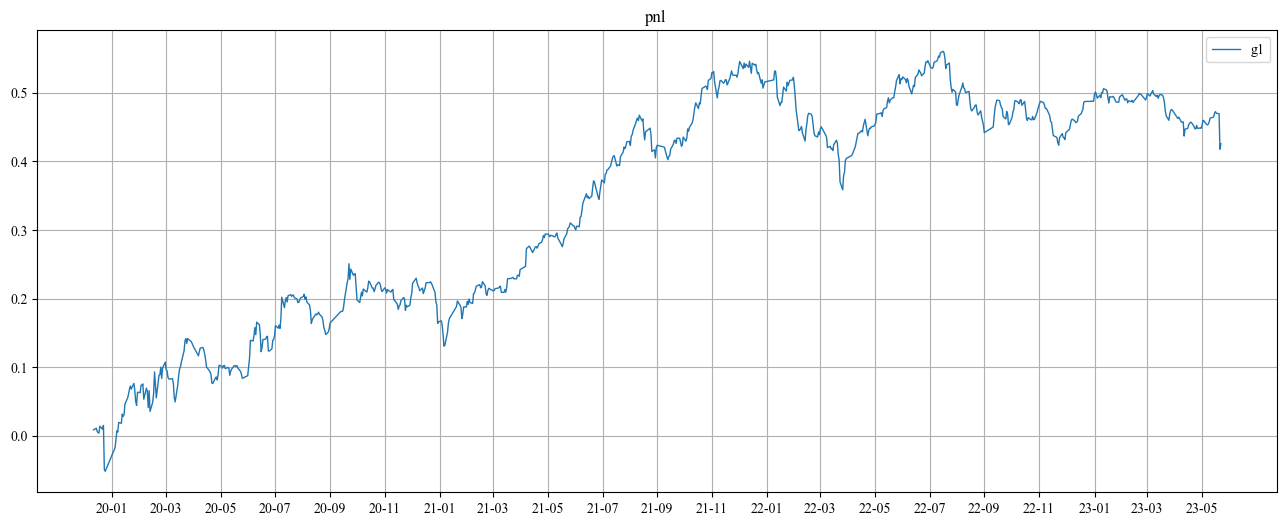

In [124]:
df = df_call_historic_vol_y
mpl.rcParams['font.family'] = 'Times New Roman'
df = df.sort_values(['order_book_id','date'])
data = df
# 构建因子 
# df['factor1'] = np.where(df.order_book_id == df.order_book_id.shift(20),df.close/df.close.shift(20)-1,np.nan)
factor = 'price_diff_250'
# 预测收益
df['r'] = np.where(df.order_book_id == df.order_book_id.shift(2),df.open.shift(-2)/df.open.shift(-1)-1,0)
r= 'r'
data = df[['date','order_book_id','r',factor]].dropna()
data = data[~np.isinf(data['r'])]
data['date'] = data['date'].apply(lambda x:str(x)[:10])
look(data,factor,r,thresh=0.01, div_num=20)
analyse_ic(data,factor,r)    
analyse_group(data,factor,r,num_group=5)
analyse_group(data,factor,r,num_group=1)

In [126]:
'''
分层回测
'''
def analyse_group_new(data,factor,y,is_alpha=False,num_group=5,figsize=(16,5)): 
    name = 'abosolute group test' if is_alpha == False else 'relative group test'
    # 数据准备
    data = data[['date',factor,y]].dropna()    
    labels=range(1,num_group+1)            
    def cut(x):
        ### 分组函数
        x[factor],cut_bin = pd.qcut(x[factor].rank(method='first'),q=num_group,labels=labels,retbins = True,duplicates='drop')   
        if is_alpha == True:
            x[y] = x[y] - x[y].mean() 
        return x
    # 分桶
    data  = data.groupby(['date']).apply(lambda x:cut(x))
    # 日收益
    dates = data['date'].sort_values().unique()
    result = data.groupby(['date',factor])[y].mean().reset_index().set_index(['date'])   
    df_r = pd.DataFrame(index=dates)
    for label in labels:
        df_r[label] = result[result[factor]==label][y].fillna(0)  
    df_pnl = df_r.cumsum()   
    # 画图
    plot_df(df_pnl,freq=2,name=name,locator='Month',figsize=figsize,area=False,ymin=0.8)   